In [644]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import datetime
import json
from nltk import ngrams
from itertools import combinations
from collections import Counter
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
from IPython.display import Image, display, Markdown
from PIL import Image as PILImage
from scipy import stats
from tqdm import tqdm
from helpers import *
from nltk.tokenize import word_tokenize

# initialize tqdm for pandas
tqdm.pandas()
# turn off the SettingWithCopyWarning
pd.options.mode.chained_assignment = None
# turn off warnings
import warnings
warnings.filterwarnings('ignore')

# define path
DIR = ".\\data"
PATH_DF_CHANNELS = DIR + '\\df_channels_en.tsv.gz'
PATH_DF_TIMESERIES = DIR + '\\df_timeseries_en.tsv.gz'
PATH_YT_METADATA = DIR + '\\yt_metadata_en.jsonl.gz'
PATH_NUM_COMMENTS = DIR  + '\\num_comments.tsv.gz'

PLOTS = ".\\plots\\"

In this notebook we want to focus on the analysis of tech review channels to understand what are the main factors of success for the YouTubers in this category.

After the preprocessing of the data, the analysis is divided into the following parts:
1. General characteristics of successful tech review channels:
    - [What is the optimum duration of a tech review video is](#video-duration)?
    - [What should be the upload frequency](#upload-frequency)?
    - [How does the review product type influence the channels' growth](#review-product-types)?
2. Attracting viewers by title:
    - [How should be the overall sentiment of the title](#titles-sentiment)?
3. Big tech product releases:
    - [Does releasing a video about a newly released tech product influence the channels' growth](#videos-about-the-events)?
    - [What topics of videos before and after the product release accelarates the channels' growth](#topics-of-videos)?

_p.s. all the cells that start with the comment `Create a plotly visualization` are meant to create the interactive visualization of the plots above them._

# Preprocessing

For filtering the tech review channels we are using the following method:

We are first creating 2 lists with the words used in tags and titles of the videos of the most popular Tech Review YouTubers, and using these 2 lists to classify all the videos (in "Education" and "Science and Technology" categories only) to tech review videos. Then, we are classifying the channels into tech review channels depending on what fraction of all of their videos are about tech review.

In [6]:
# filter metadata only considering the videos in "Education" and "Science & Technology"
dfs = []
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json = df_json[['channel_id','display_id','duration','tags','title','categories']]
    df_json = df_json[(df_json['categories'] == 'Education') | (df_json['categories'] == 'Science & Technology')]
    
    dfs.append(df_json)
df_tech = pd.concat(dfs)
df_tech.drop('categories',axis=1,inplace=True)

# some videos don't define and tag, so we set them to an empty string
df_tech['tags'].fillna('',inplace=True)


# select the videos of the most popular tech review channels
df_channels = pd.read_csv(PATH_DF_CHANNELS, compression="infer", sep="\t")

popular_tech_channels = ['Marques Brownlee','Mrwhosetheboss','iJustine','UrAvgConsumer',
                         'Unbox Therapy','Linus Tech Tips','The Tech Chap','MrMobile [Michael Fi...']
popular_tech_channels_id = df_channels[df_channels.name_cc.isin(popular_tech_channels)].channel.unique()
df_tech_pop = df_tech[df_tech.channel_id.isin(popular_tech_channels_id)][['tags','title']]


# Find the most commonly used words both in tags and titles of the above videos
print('Cleaning title')
df_tech_pop['clean_title'] = df_tech_pop.title.progress_apply(clean_text)
print('Cleaning tags')
df_tech_pop['clean_tags'] = df_tech_pop.tags.progress_apply(clean_text)

# create a single list for all the words in both tags and titles
all_tags = []
all_titles = []
for tags in df_tech_pop.clean_tags.values:
    all_tags += tags
for titles in df_tech_pop.clean_title.values:
    all_titles += titles


# clean title and tags of all the videos
df_tech_review = df_tech.copy()
print('Cleaning all titles')
df_tech_review['clean_title'] = df_tech_review.title.progress_apply(clean_text)
print('Cleaning all tags')
df_tech_review['clean_tags'] = df_tech_review.tags.progress_apply(clean_text)

Loading data: 730it [30:12,  2.48s/it]                               


Cleaning title


100%|██████████| 10234/10234 [00:17<00:00, 596.64it/s]


Cleaning tags


100%|██████████| 10234/10234 [00:49<00:00, 205.00it/s]


Cleaning all titles


100%|██████████| 6198568/6198568 [2:25:31<00:00, 709.94it/s]  


Cleaning all tags


100%|██████████| 6198568/6198568 [8:35:16<00:00, 200.49it/s]    


To classify the videos into tech review, we are using the following method:


First, we get the 100 most commonly used words in the titles of the videos of the most popular tech review youtubers on youtube (call it TITLES_COMMON). Then, for each video calculate what percentage of the words used in their titles occurs in TITLES_COMMON, and we repeat this proces for tags as well. Finally, if the duration of the video is less than 20 minutes, and at least 50% of the words used either in its title or tags are the ones used in TITLES_COMMON, or TAGS_COMMON, then we set this video as "tech review".

**The most occured words in tags**

iphone - review - unboxing - best - tech - galaxy - android - gaming - samsung - apple - pro - smartphone - phone - new - gadget - video - camera - plus - note - unbox - therapy - game - technology - headphone - oneplus - pc - laptop - google - ipad - pixel - cool - computer - beat - unboxtherapy - test - one - wireless - macbook - lg - top - tip - xbox - huawei - case - nexus - sony - setup - hd - battery - youtube - monitor - linus - tv - invention - playstation - asus - bluetooth - speaker - chap - nvidia - uravgconsumer - giveaway - consumer - max - ce - first - htc - mate - tour - xl - mkbhd - intel - gtx - air - apps - overview - smart - watch - card - edge - io - audio - hand - edition - core - keyboard - look - system - budget - build - display - razer - mobile - tablet - average - high - cheap - industry - amazon - nintendo

**The most occured words in titles**

tech - unboxing - tip - linus - first - review - look - gaming - iphone - pc - galaxy - pro - best - new - samsung - hd - chap - show - smartphone - ce - phone - asus - wan - gtx - video - case - overview - android - card - laptop - edition - test - camera - top - apple - one - giveaway - google - core - ultimate - intel - wireless - ijustine - nvidia - motherboard - headphone - monitor - note - amd - drive - corsair - setup - oneplus - keyboard - cpu - lg - geforce - plus - tutorial - performance - hand - impression - part - msi - gb - cooler - mouse - ipad - world - ssd - power - game - huawei - tv - guide - buy - day - macbook - razer - ever - pixel - computer - series - sony - youtube - usb - update - mini - speaker - headset - gadget - window - comparison - tour - beat - nexus - full - gigabyte - life - watch

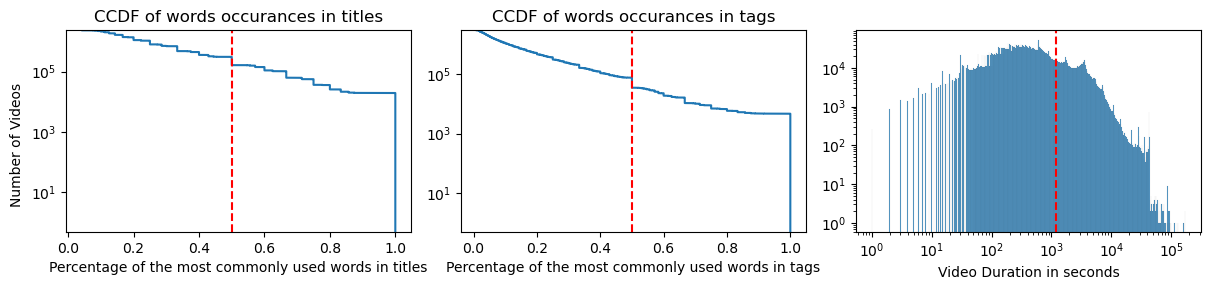

In [8]:
# get 100 most commonly used words in tags and titles of the most popular youtubers
tags_common = get_common_words(all_tags).rename({'word':'tags_unique','occurance':'tags_occurance'},axis=1)
titles_common = get_common_words(all_titles).rename({'word':'titles_unique','occurance':'titles_occurance'},axis=1)

# display the most occured words in tags and titles
markdown_tags = " - ".join(tags_common['tags_unique'].to_list())
markdown_titles = " - ".join(titles_common['titles_unique'].to_list())
display(Markdown('**The most occured words in tags**\n\n' + markdown_tags))
display(Markdown('**The most occured words in titles**\n\n' + markdown_titles))

# count the number of occurances of the above words in the tags/title of each video
df_tech_review['tags_occurances_perc'] = df_tech_review['clean_tags'].apply(lambda tags: 0 if len(tags) == 0 else (np.intersect1d(tags, tags_common['tags_unique'].unique()).shape[0] / len(tags)))
df_tech_review['title_occurances_perc'] = df_tech_review['clean_title'].apply(lambda title: 0 if len(title)==0 else (np.intersect1d(title, titles_common['titles_unique'].unique()).shape[0] / len(title)))

# plot the words distribution to highlight how we are filtering the tech review videos
fig, axes2 = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
sns.ecdfplot(x = df_tech_review[df_tech_review.title_occurances_perc > 0].title_occurances_perc, complementary=True, stat='count', log_scale=(False, True), ax=axes2[0])
sns.ecdfplot(x = df_tech_review[df_tech_review.tags_occurances_perc > 0].tags_occurances_perc, complementary=True, stat='count', log_scale=(False, True), ax=axes2[1])
sns.histplot(x = df_tech_review.duration, stat='count', log_scale=(True, False), ax=axes2[2])
axes2[0].axvline(x=0.5, color='red', linestyle='--')
axes2[1].axvline(x=0.5, color='red', linestyle='--')
axes2[2].axvline(x=1200, color='red', linestyle='--')
axes2[0].set(title='CCDF of words occurances in titles',xlabel='Percentage of the most commonly used words in titles', ylabel=None, yscale='log')
axes2[1].set(title='CCDF of words occurances in tags', xlabel='Percentage of the most commonly used words in tags', ylabel=None, yscale='log')
axes2[2].set(xlabel='Video Duration in seconds', ylabel=None, yscale='log')
fig.text(-0.005, 0.5, 'Number of Videos', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

We filter the videos that have more than 50% of the words of their title or tags are the ones found in the most commongly used words list. Then, we filter the channels that are in Education or Science & Technology category and have more than 5% of their videos in tech review. Note that the category of the channels is assigned by the socialblade platform depending on the last 10 videos published at the time of crawl.

In [9]:
# tech review videos only
df_tech_review_videos = df_tech_review[(df_tech_review.duration < 1200) & ((df_tech_review.tags_occurances_perc > 0.5) | (df_tech_review.title_occurances_perc > 0.5))]

# count the number of tech review videos per channel
count_tech_videos = df_tech_review_videos.groupby('channel_id',as_index=False)[['display_id']].count().rename({'display_id':'count_tech_videos'},axis=1)

# assign the number of tech review videos for each channel
df_tech_channels = pd.merge(df_channels.rename({'channel':'channel_id'},axis=1), count_tech_videos, how='left', on='channel_id')
df_tech_channels.loc[df_tech_channels.count_tech_videos.isna(), 'count_tech_videos'] = 0

# get the percentage of tech review videos
df_tech_channels['tech_videos_perc'] = df_tech_channels['count_tech_videos'] / df_tech_channels['videos_cc']

# tech review channels only
df_tech_review_channels = df_tech_channels[(df_tech_channels.tech_videos_perc > 0.05) & (df_tech_channels.category_cc.isin(['Education','Science & Technology']))].drop(['category_cc','tech_videos_perc'],axis=1).reset_index(drop=True)
display(df_tech_review_channels.sample(5))

,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos
406,2014-12-29,UCWVyEdLMP9b6P0FOSkripLQ,TecworkZ,120198,301,131463.0,4.3110,178.0
1212,2010-01-25,UCQT1rbzlJPiwFEBNeDbJDvQ,Andy Rox,11000,77,849534.0,15.3200,7.0
269,2014-09-25,UC_nPskT9hNIUUYE7_pZK5pw,BEST REVIEWS,213000,781,78859.0,3.6855,87.0
1200,2015-09-17,UCBl1nL13BmieYFD9f1ZBS8Q,Arindam Sen,12366,38,834445.0,12.1815,2.0
418,2006-10-17,UCxn2JKjtfOy5qr1pnen79Fw,TigerDirect,114000,4338,136294.0,5.5140,342.0


Now from the youtube videos metadata, we want to filter the tech review channels only, keeping all of their videos from original metadata (both tech and non-tech).

In [10]:
# filter metadata
dfs = []
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date"], inplace=True, axis=1)
    df_json = df_json[df_json.channel_id.isin(df_tech_review_channels.channel_id.unique())]
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    
    dfs.append(df_json)
df_tech_review_mt = pd.concat(dfs)

# flag tech videos
df_tech_review_mt.loc[df_tech_review_mt.display_id.isin(df_tech_review_videos.display_id.unique()),'tech_review'] = True
df_tech_review_mt.tech_review.fillna(False, inplace=True)

# add number of comments
num_comments = pd.read_csv(PATH_NUM_COMMENTS, compression="infer", sep="\t")
df_tech_review_mt = pd.merge(df_tech_review_mt, num_comments, on='display_id', how='left')

# clean title and tags
print('Cleaning all titles')
df_tech_review_mt['clean_title'] = df_tech_review_mt.title.progress_apply(clean_text)
print('Cleaning all tags')
df_tech_review_mt['clean_tags'] = df_tech_review_mt.tags.progress_apply(clean_text)

Loading data: 730it [32:24,  2.66s/it]                               


Cleaning all titles


100%|██████████| 740018/740018 [16:35<00:00, 743.45it/s] 


Cleaning all tags


100%|██████████| 740018/740018 [1:09:32<00:00, 177.35it/s] 


With that we will be done with preprocessing with 2 datasets in our hand to be used throughout the analysis:
- df_tech_review_channels: Channel Data for tech review channels only
- df_tech_review_mt: Video Meatadata of tech review channels only

Here is a sample of the 2 preprocessed datasets:

In [4]:
print('Number of videos selected:',df_tech_review_mt.shape[0])
df_tech_review_mt.sample(5)

Number of videos selected: 740018


,categories,channel_id,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,tech_review,num_comms,clean_title,clean_tags
208581,Science & Technology,UCxOD5c7H4zepc1_Q-AbJNMg,28.0,MQGFyIRHdXg,430,607.0,"sony,sony xperia z,android,smartphone,ces,ces ...",Sony Mobile XPERIA Z in detail,2013-01-07,224429.0,False,180.0,"['sony', 'mobile', 'xperia', 'detail']","['sony', 'sony', 'xperia', 'android', 'smartph..."
731058,Science & Technology,UCsW36751Gy-EAbHQwe9WBNw,64.0,tPEoF8HVqpY,290,1711.0,"vizio,vizio p series,vizio p series unboxing,v...",Vizio P-Series 4K HDR Home Theater Display Unb...,2016-06-12,123973.0,False,242.0,"['vizio', 'series', 'hdr', 'home', 'theater', ...","['vizio', 'vizio', 'series', 'vizio', 'series'..."
673299,People & Blogs,UCu5NXBf3NVuP8PYH-a5uedw,8.0,Ic6V1mmPeQQ,104,37.0,"Huawei,Huawei P9,Huawei P9 Lite,Huawei P8,Huaw...",Huawei G9 Lite (G9 Youth) first look,2017-02-01,7037.0,False,8.0,"['huawei', 'lite', 'youth', 'first', 'look']","['huawei', 'huawei', 'huawei', 'lite', 'huawei..."
44014,Science & Technology,UCyykoNzuB2AxrPm8CJa2Jgw,2.0,V1BopJsbJXI,271,2.0,"ASUS (Computer Manufacturer/Brand),Grand Theft...",GTA V Ultimate graphic benchmark (ASUS R9 290),2015-04-30,1254.0,False,2.0,"['gta', 'ultimate', 'graphic', 'benchmark', 'a...","['asus', 'computer', 'manufacturer', 'brand', ..."
387027,Science & Technology,UCOmcA3f_RrH6b9NmcNa4tdg,30.0,1-Pb7EvF5g4,186,69.0,"cbsepisode,First,Look,Lenovo (Organization)",Lenovo IdeaPad U310 - First Look,2012-07-03,13677.0,False,42.0,"['lenovo', 'ideapad', 'first', 'look']","['cbsepisode', 'first', 'look', 'lenovo', 'org..."


In [5]:
print('Number of channels selected:',df_tech_review_channels.shape[0])
df_tech_review_channels.sample(5)

Number of channels selected: 1250


,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos
784,2016-03-07,UCspZF0GE749o4U0upQuHcAQ,Royal Tech,36264,177,368124.0,8.9525,27.0
825,2011-02-04,UCOnA4oZccE0dxZjI733EjSw,GadgetsBoy,31657,957,401418.0,7.7630,249.0
1034,2014-01-29,UCd8_HyWNvLELqVg2QIoXPAA,Bingocat,17300,138,610760.0,9.6125,16.0
563,2008-07-12,UCyX42PelLL-qrnr1i9w5K-w,Clove Technology,66800,1579,209714.0,5.6000,407.0
157,2015-04-29,UCI8iQa1hv7oV_Z8D35vVuSg,Hardware Unboxed,406000,1133,40933.0,3.3740,124.0


# General characteristics of successful tech review channels

In [2]:
### to be removed ###
PATH_YT_TECH_CHANNELS_METADATA = '.\\data\\clean' + '\\yt_tech_channels_metadata.tsv.gz'
PATH_TECH_CHANNELS = '.\\data\\clean' + '\\tech_review_channels.tsv.gz'

df_tech_review_mt = pd.read_csv(PATH_YT_TECH_CHANNELS_METADATA, sep="\t", compression="infer")
df_tech_review_mt = df_tech_review_mt.drop('Unnamed: 0',axis=1)
df_tech_review_channels = pd.read_csv(PATH_TECH_CHANNELS, sep="\t", compression="infer")
df_tech_review_channels = df_tech_review_channels.drop('Unnamed: 0',axis=1)
######

## Video duration

### Analysis of videos of less than 20 minutes (currently preprocessed videos)

Let's start off with the analysis of a video duration. We can take the number of likes and dislikes as metrics of a video. We first want to know if there is any correlation between likes/dislikes and the duration of a video. Below, we are calculating the pearson correlation between the number of like/dislikes and the duration of a video. We decided to do the pearson correlation, as the correlation is linear (to be seen later)

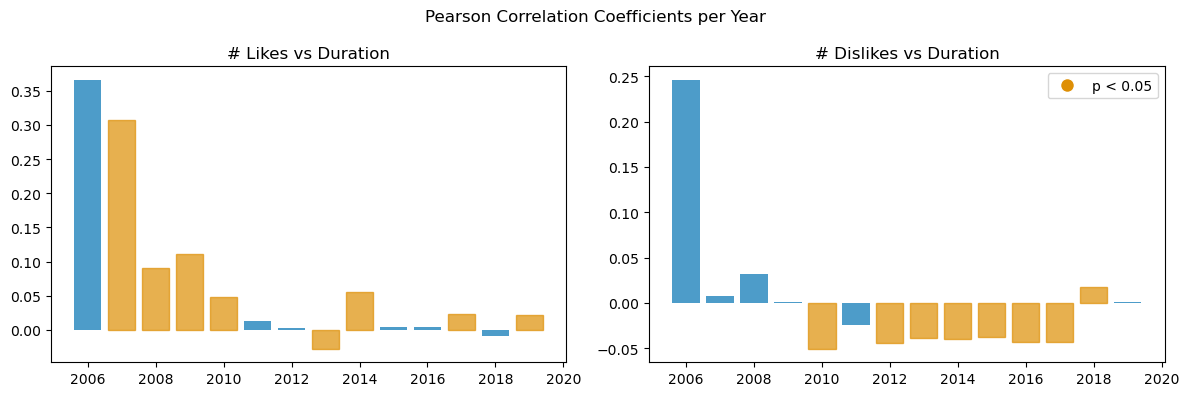

In [13]:
# filter only the tech review videos by tech review channels
df_vd_tech = df_tech_review_mt[df_tech_review_mt.tech_review]
df_vd_tech["upload_date"] = pd.to_datetime(df_vd_tech["upload_date"])
df_vd_tech["upload_year"] = df_vd_tech['upload_date'].dt.year

# plot the correlation between the duration of the video and number of likes and dislikes
df_corrs_pearson_like, df_corrs_pearson_dislike = get_correlations(df_vd_tech)
plot_correlations(df_corrs_pearson_like, df_corrs_pearson_dislike)

There is a relatively high positive correaltion (that is decreasing across the years), but significant (p_value < 0.05) between the duration of a video and the number of likes it gets. This is different from causation (i.e this does NOT mean that by uploading a longer video we will get more likes) but this nonetheless means that with longer videos we tend to have a bigger number of likes. Moreover, we see that with longer videos the number of dislikes decreases (significant negative correlation in most years between # of dislikes and duration) which further proves the point.

This can be explained by the fact that with longer videos on average, the video contains more content and so is more valuable/interesting and thus gets more likes. Note that here we are looking at videos of duration less than 20 minutes which means less number of ads in the video and a less lengthy/boring video. We will later look at videos of more than 20 minutes to see whether this changes or not.

Let's see how do top and worst channels (in terms of like-dislike ratio) relate to this.

In [14]:
df_vd_tech_ratio = compute_ratios_and_print_duration(df_vd_tech)

The average duration of a video from the top 10% of channels (in terms of like to dislike ratio) is 375 seconds and the average duration of a video from the bottom 10% of channels is 351.
Ttest_indResult(statistic=8.441690694848564, pvalue=3.273991080221707e-17)


We see that the "top" channels (the ones that have a higher like to dislike ratio on their videos) have longer videos on average (375 seconds compared to 351 seconds) and this difference is statistically significant (p-value < 0.05).

Let's now see the trend of likes, dislikes, and duration to take their evolution into consideration. 

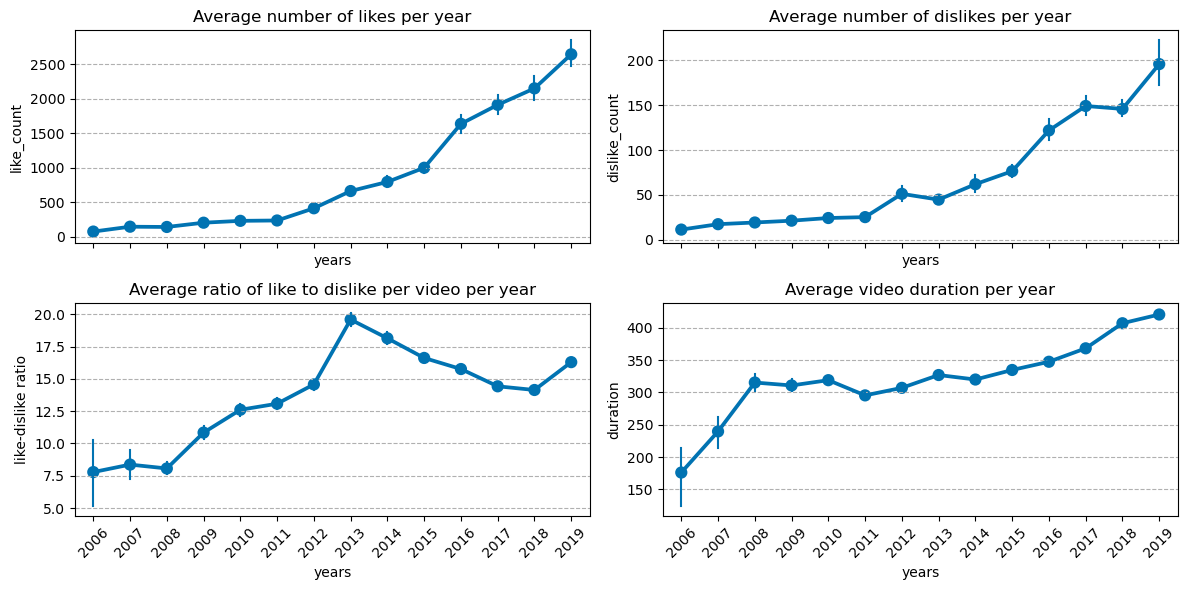

In [19]:
plot_helper(df_vd_tech)

We see from the above plot that both number of dislikes and likes have been increasing across the years. Multiple reasons can justify this: for instance this could be due to more users on the platform or more user engagement (users engage with the content and give their opinion which can be positive or negative, instead of saying nothing).

We can also see that the length of youtube videos has been increasing over the years: it went from 200 seconds (~3.3 minutes) in 2006 to more than 400 seconds (~6.6 minutes) in 2019 on average. This can be explained by the various technological advancements (bigger memory space to store and upload the videos, better camera battery, camera portability, etc), and to the higher creativity youtubers have to film longer videos that have more content.

However, much higher increase rate of number of likes compared to the one of dislikes can explain the correlations we had in the previous plots. Namely, why we had higher correaltion between Likes and Duration, and less correlation between Dislikes and Duration.


Let's now see how the video duration is related to a user engagement. We do it by plotting the moving average of likes to dislikes ratio over the duration of a video.

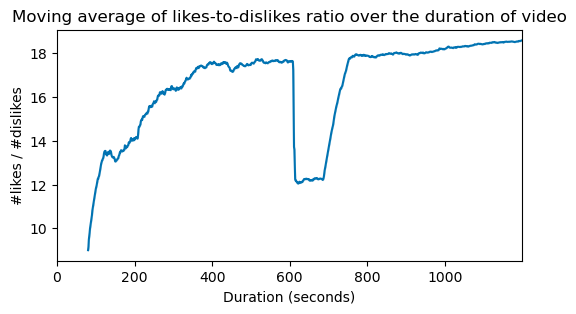

In [20]:
plot_moving_avg(df_vd_tech_ratio, 10000, True)

We can see from this plot that generally the longer videos (for videos up to 20min) tend to be liked more by the users, except for the videos between 10 - 11 minutes. This could be because of an enormous number of videos on YouTube with this duration, which might include a lot of low quality videos as well, as youtubers usually try to produce videos around 10 minutes to benefit from more ads on their videos (Youtube has a video length threshold of 10 min past which youtubers get 2 ads on their videos and thus more money). We analyse this drop further.

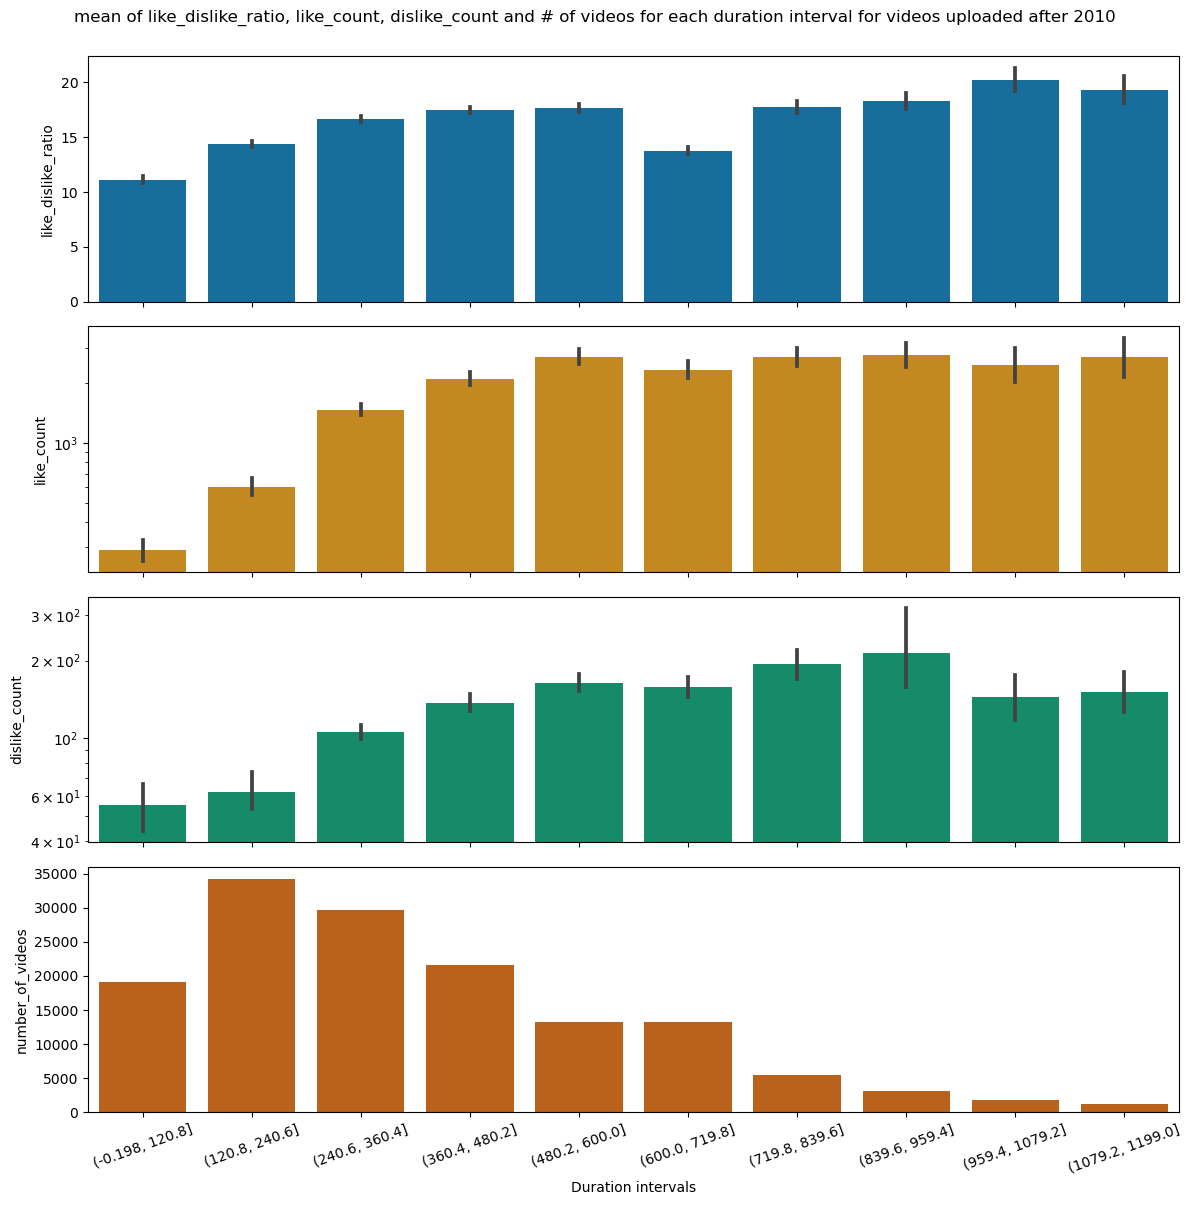

In [75]:
plot_statistics_across_duration_intervals(df_vd_tech_ratio, 2004)

We see that even by plotting the mean for each time interval (not 'moving') the drop is still there. Also, we notice that the number likes decreased but the number of dislikes and number of videos stayed the same between the 10 min interval and the interval before it.

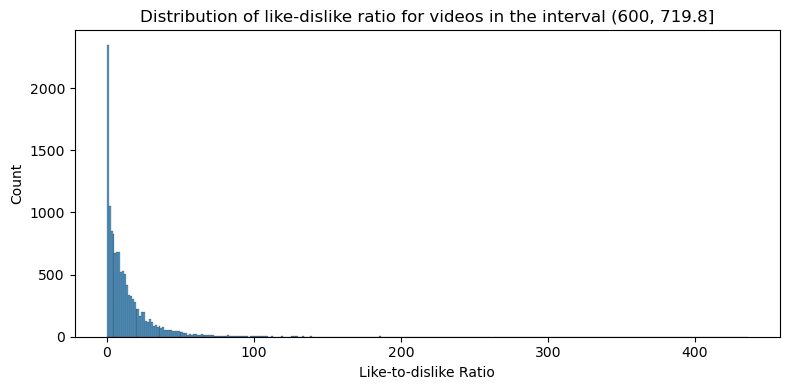

In [46]:
#plot the distribution of like-dislike ratio for the 10 min interval
plt.figure(figsize=(8, 4))
sns.histplot(
        data=df_vd_tech_ratio[df_vd_tech_ratio['duration_intervals'] == (pd.Interval(600, 719.8))], 
        x='like_dislike_ratio', 
        palette='colorblind'
    ).set(
        title='Distribution of like-dislike ratio for videos in the interval (600, 719.8]',
        xlabel='Like-to-dislike Ratio'
    )
plt.tight_layout()
plt.show()

We see that, for the time interval 600 to 719.8 seconds (10 minutes to 12 minutes) the distribution of likes to dislikes ratio follows a heavy tailed distribution (most videos have a low like to dislike ratio while few have a really high like to dislike ratio). Therefore, it might not be optimal to plot the mean for the like to dislike ratio but instead the median. 

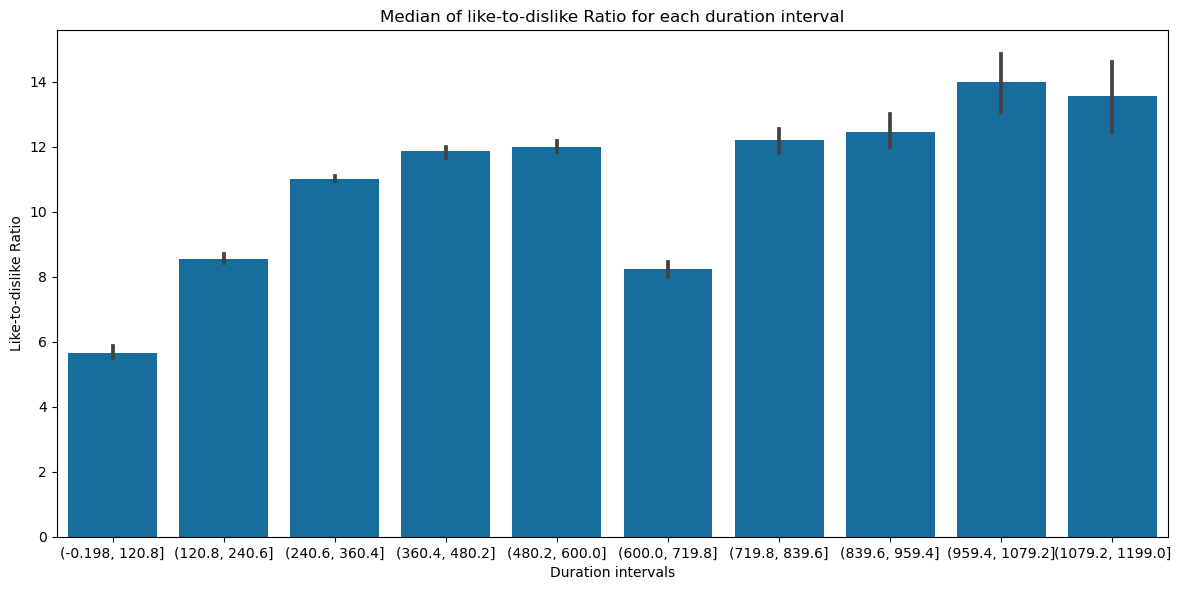

In [48]:
#plot the median of like-dislike ratio for each interval
plt.figure(figsize=(12, 6))
color = sns.color_palette("colorblind",1)
sns.barplot(
        data=df_vd_tech_ratio, 
        x='duration_intervals',
        y= 'like_dislike_ratio',
        estimator ='median',
        color=color[0]
    ).set(
        title='Median of like-to-dislike Ratio for each duration interval',
        xlabel='Duration intervals',
        ylabel='Like-to-dislike Ratio'
    )
plt.tight_layout()
plt.show()

Unfortunately, even with the median we see the same drop. This is can be justified by the fact that there are a lot of videos with low like to dislike ratio and so the median becomes really close to the minimum which is not insightful. What if we try to plot the sum of likes to dislikes ratios for each time interval? We do this next.

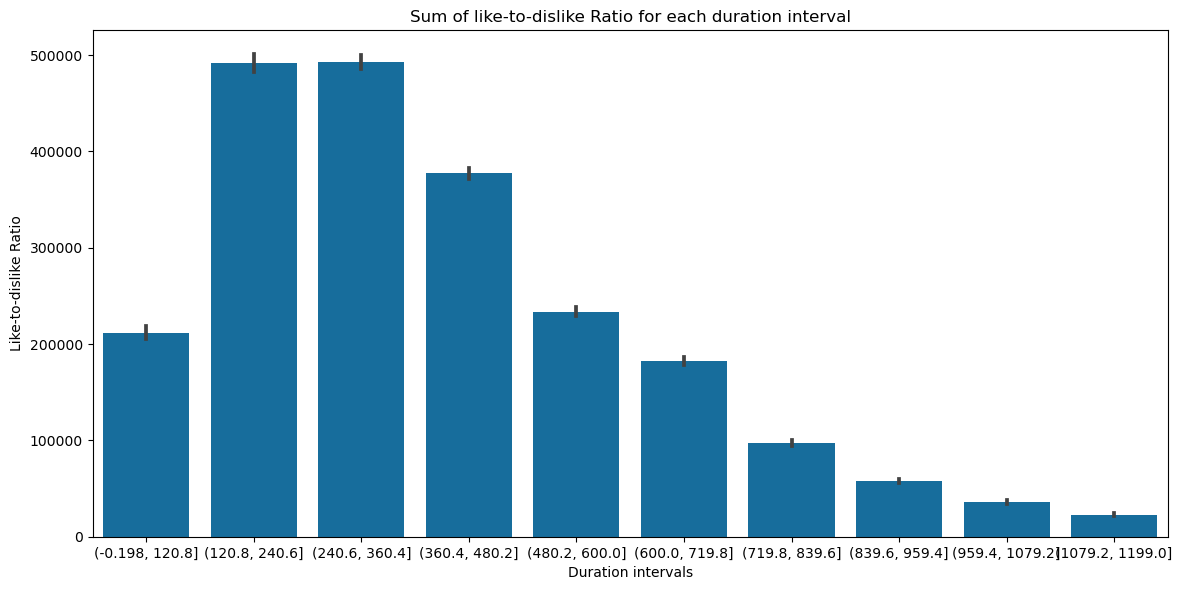

In [49]:
#plot the sum of like-dislike ratio for each interval
plt.figure(figsize=(12, 6))
color = sns.color_palette("colorblind",1)
sns.barplot(
        data=df_vd_tech_ratio, 
        x='duration_intervals',
        y= 'like_dislike_ratio',
        estimator ='sum',
        color=color[0]
    ).set(
        title='Sum of like-to-dislike Ratio for each duration interval',
        xlabel='Duration intervals',
        ylabel='Like-to-dislike Ratio'
    )
plt.tight_layout()
plt.show()

We see from the above plot that the sum is decreasing from small duration to high duration (from the left time interval to the right time interval), but the _number of videos_ stayed the same for the 2 time intervals (480.2, 600] and (600, 719.8] which explains the drop seen when computing the mean (as we have the same denominator but a lower numerator: the like to dislike ratio is decreasing from small duration to high duration, whereas the number of videos has been decreasing from small duration to high duration **except** for the time interval of around 600 seconds = 10 minutes). 

But why is the number of videos the same for those 2 duration intervals? From 2006 to 2010, youtube introduced a ten-minute limit on the length of videos after noticing that the majority of videos exceeding this length were unauthorized uploads of television shows and films. This might bias our analysis as this could push the number of videos around 10 minutes up, because people can't upload a video of more than that duration and so they would be condensed around that video length, thus explaining why we have the same number of videos at around 10 minutes.

In [15]:
print("The total number of tech review videos from 2005 to 2019 is: ", len(df_vd_tech_ratio))
print("The total number of tech review videos from 2010 to 2019 is: ", len(df_vd_tech_ratio[df_vd_tech_ratio['upload_year']>2010]))

The total number of tech review videos from 2005 to 2019 is:  142615
The total number of tech review videos from 2010 to 2019 is:  137170


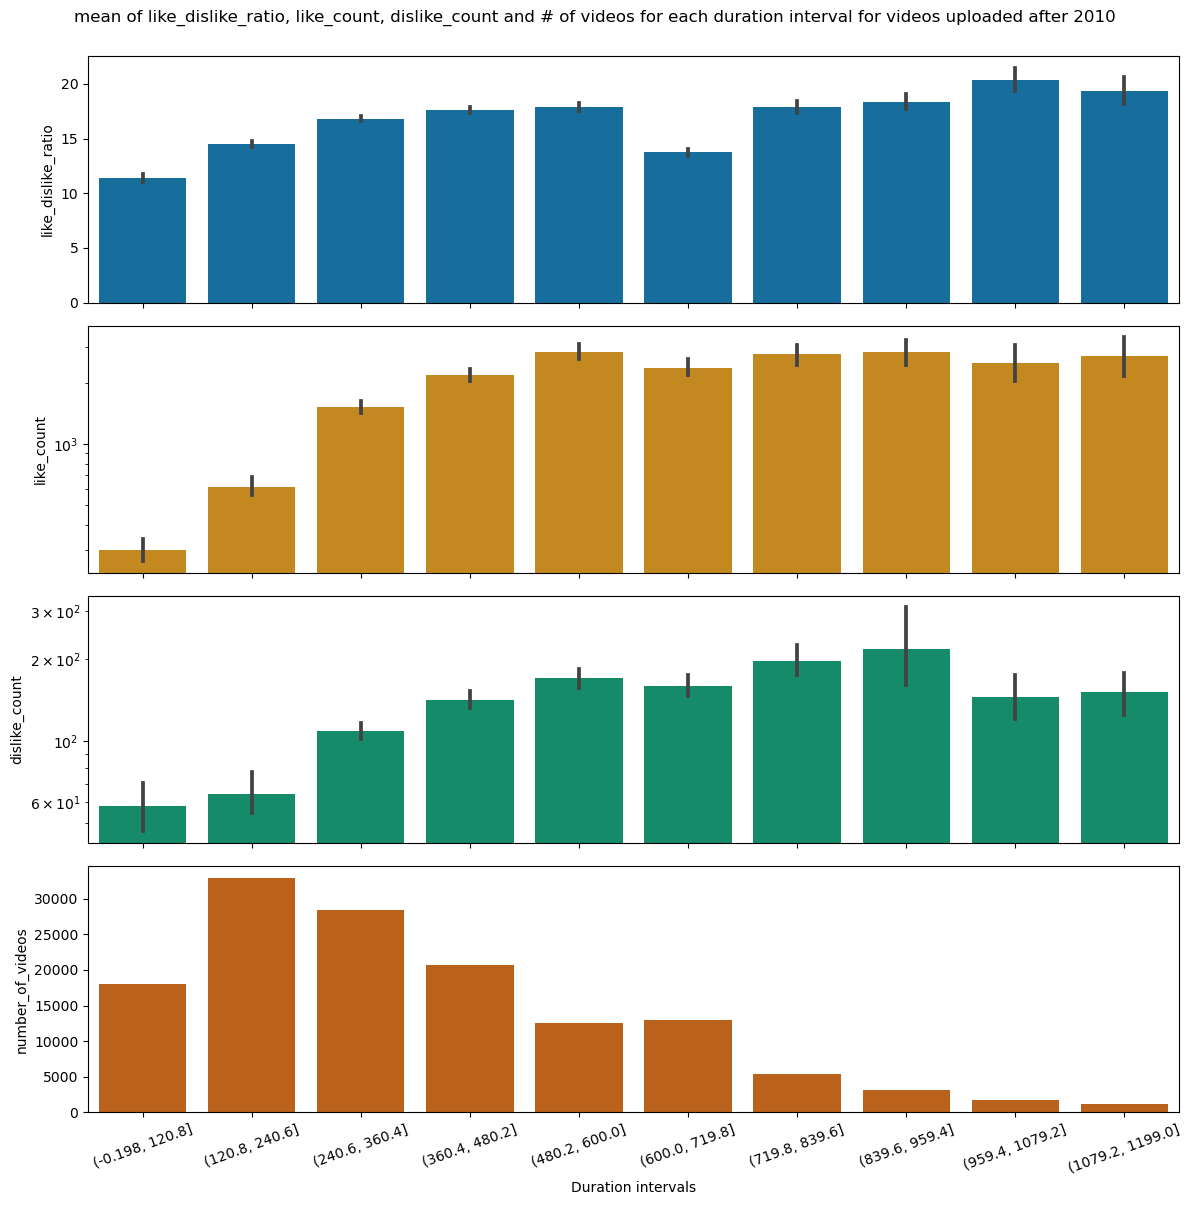

In [16]:
plot_statistics_across_duration_intervals(df_vd_tech_ratio, 2010)

By only keeping the videos uploaded starting from 2011, we see that the number of videos goes from 142000 to 137000  which is not signifciant to bias our study, and which makes sense as youtube wasn't that popular from 2006 to 2010 and not many people became youtubers. To be sure we plot the above 4 plots for this period (excluding videos uploaded before 2011). We see that the trends are the same and particularly the drop in like to dislike ratio around 10 min videos is still present. 
After this analysis, we can be confident that the fact that the number of videos stayed the same for these 2 intervals is explained by the fact that youtube allows for 2 ads for videos of length passed 10 minutes, which motivates youtubers to upload videos of this length. Moreover, the number of dislikes didn't decrease significantly but it's instead the number of likes that decreased remarkably. This combined with the constant number of videos for the intervals (480.2, 600.0] and (600.0, 719.8] explain why the moving median and mean had a drop at the 10 min duration.  

We also note that the best range for duration (the one with highest like-dislike ratio) is (959.4, 1199] ~ (16min, 20with a ratio of ~20. It's important to note that this isn't a hard rule, other ranges can also be successful, and as we have seen the 10 min range is actually not to be avoided because the drop we see is due to the high number of videos in that range and to the diverse nature/quality of the videos in it.

### Analysis of videos of more than 20 minutes

Of course not all tech videos are less than 20 minutes, so now let's turn our attention to the videos of more than 20 minutes and apply the same analysis on them as we did above.

First, we filter the tech reviw videos over 20 minutes:

In [18]:
# select tech review videos over 20 minutes
df_vd_tech_long = df_tech_review[(df_tech_review.duration >= 1200) & ((df_tech_review.tags_occurances_perc > 0.5) | (df_tech_review.title_occurances_perc > 0.5))]
print('Number of videos:',df_vd_tech_long.shape[0])

Number of videos: 7770


We apply the same above analyis for videos of more than 20 minutes, that is we are calculating the pearson correlation between the number of likes/dislikes and the duration of a video.

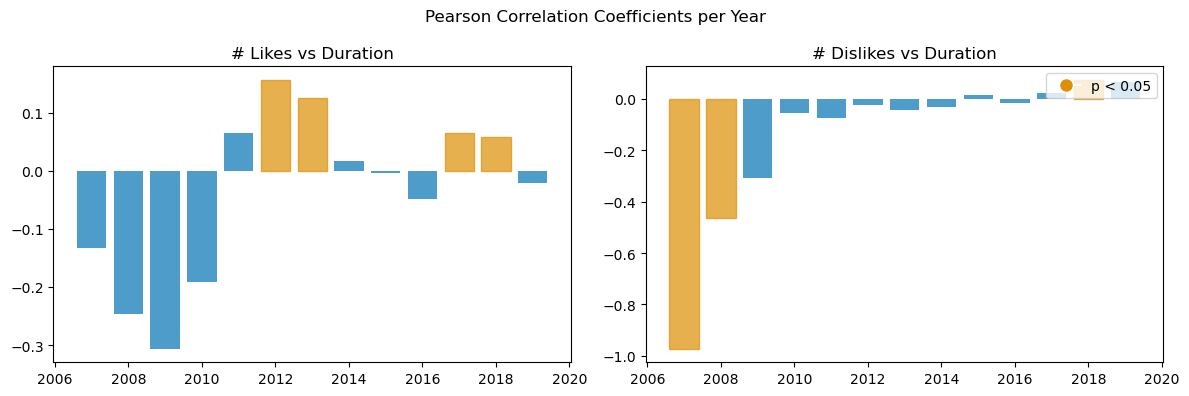

In [4]:
df_corrs_pearson_like, df_corrs_pearson_dislike = get_correlations(df_vd_tech_long)
plot_correlations(df_corrs_pearson_like, df_corrs_pearson_dislike)

We see that we no longer have that for most years, the longer the video the more likes it gets as we had for the videos of less than 20 minutes but we instead have more negative correlations appearing. This is expected as longer videos tend to be more boring. However, these negative correlations are not significant and this is because no one really watches really long videos. Furthermore, the negative correlations between the duration of a video and the number of dislikes it gets in more recent years are now less statistically significant (compared to videos of less than 20 min) and a positive correlation trend is emerging which makes sense as again usually the longer the video the more boring it is. The opposite effect is seen here compared to videos of less that 20 minutes.

Let's now see how do top and worst channels (in terms of like-dislike ratio) relate to this.

In [5]:
df_vd_tech_ratio_long = compute_ratios_and_print_duration(df_vd_tech_long)

The average duration of a video from the top 10% of channels (in terms of like to dislike ratio) is 2665 seconds and the average duration of a video from the bottom 10% of channels is 2729.
Ttest_indResult(statistic=-0.46367349529775137, pvalue=0.6429467094425946)


We see that the "top" channels (the ones that have a higher like to dislike ratio on their videos) now have shorter videos on average (2665 seconds compared to 2729 seconds) hinting that it's best to stay closer to the 20 minutes mark. However, the p-value now is larger than 0.05 and so the difference is not statistically significant. We need to further analyse this.

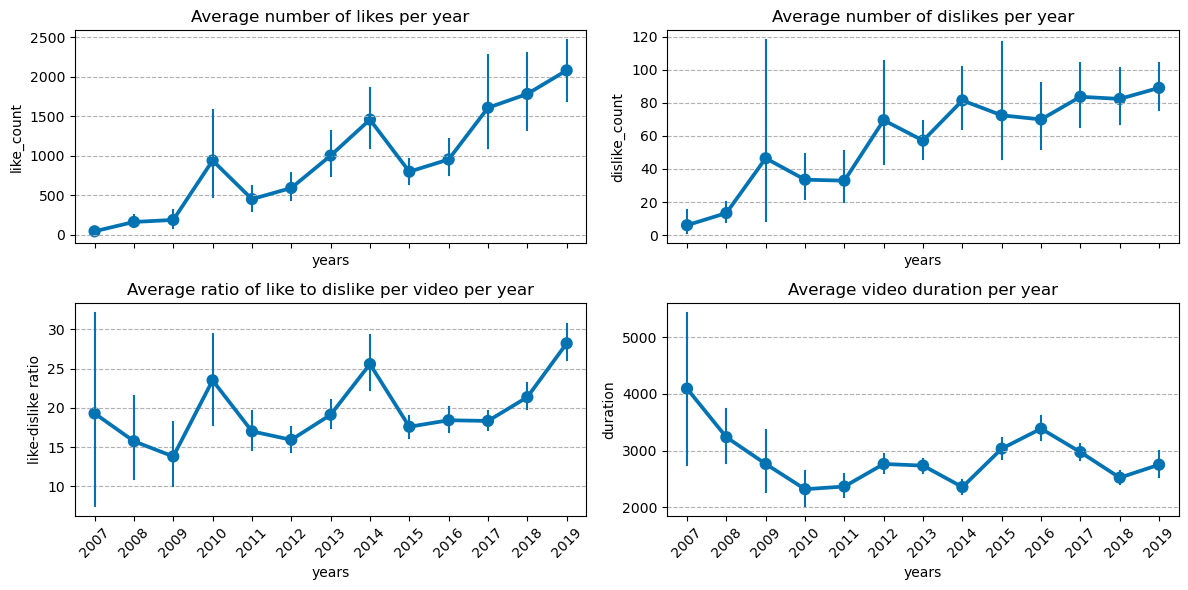

In [11]:
plot_helper(df_vd_tech_long)

We see from the above plot that both number of dislikes and likes have been increasing across the years. The same reasons as for the videos of less than 20 minutes can apply for this case. 

However, here we see that the length of youtube videos has been decreasing over the years: it went from more than 4000 seconds (66 minutes ~ 1 hour) in 2007 to less than 3000 seconds (50 minutes) in 2019 on average. This can be explained by the fact that youtbers noticed that longer videos bore people more and they thus went for shorter videos.

Particularly, the ratio of number of likes compared to dislikes has been increasing with high fluctuations/variance; one big jump in 2010 and another in 2014. For the one in 2010, this can be justified as seen before by the removal of the 10 minutes limit and so people could include more content and get more likes. For the second one, we analyse it further below.

In [84]:
print("The average video duration of a video uploaded in 2013 is {0:.0f} seconds, and in 2014 it's {1:.0f}s and in 2015 it's {2:.0f}s".format(df_vd_tech_ratio_long[df_vd_tech_ratio_long['upload_year']==2013].duration.mean(), df_vd_tech_ratio_long[df_vd_tech_ratio_long['upload_year']==2014].duration.mean(),df_vd_tech_ratio_long[df_vd_tech_ratio_long['upload_year']==2015].duration.mean()))

#compute ttest between duration means of videos uploaded in 2013 and 2014  
stat = stats.ttest_ind(df_vd_tech_ratio_long[df_vd_tech_ratio_long['upload_year']==2013].duration, df_vd_tech_ratio_long[df_vd_tech_ratio_long['upload_year']==2014].duration)
print('Ttest between duration means of videos uploaded in 2013 and 2014:',stat)

#compute ttest between duration means of videos uploaded in 2014 and 2015  
stat = stats.ttest_ind(df_vd_tech_ratio_long[df_vd_tech_ratio_long['upload_year']==2014].duration, df_vd_tech_ratio_long[df_vd_tech_ratio_long['upload_year']==2015].duration)
print('Ttest between duration means of videos uploaded in 2014 and 2015:',stat)

The average video duration of a video uploaded in 2013 is 2737 seconds, and in 2014 it's 2359s and in 2015 it's 3036s
Ttest between duration means of videos uploaded in 2013 and 2014: Ttest_indResult(statistic=4.1494218124798365, pvalue=3.538148456091029e-05)
Ttest between duration means of videos uploaded in 2014 and 2015: Ttest_indResult(statistic=-5.836749209073462, pvalue=6.597159443315029e-09)


We see that there's is a statistcally significant difference between the duration average of a video from 2013, 2014 and 2015. 2014 had the lowest average duration and the highest like-dislike ratio of the 3 years, thus hinting towards the idea that people prefer shorter videos over longer ones and providing an explanaiton to why we observe the peak in 2014. 

Let's now see how the video duration is related to user engagement. We do it by plotting the moving average of likes to dislikes ratio over the duration of a video.

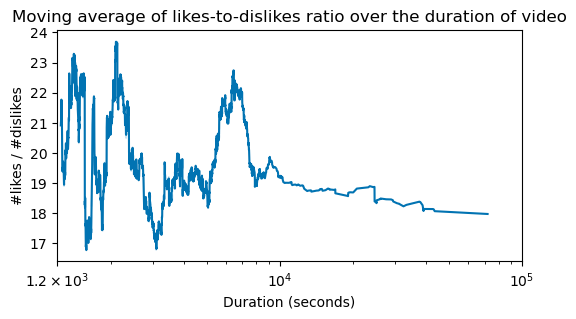

In [9]:
plot_moving_avg(df_vd_tech_ratio_long, 500, False)

To analyse this plot well we also plot the below 4 plots.

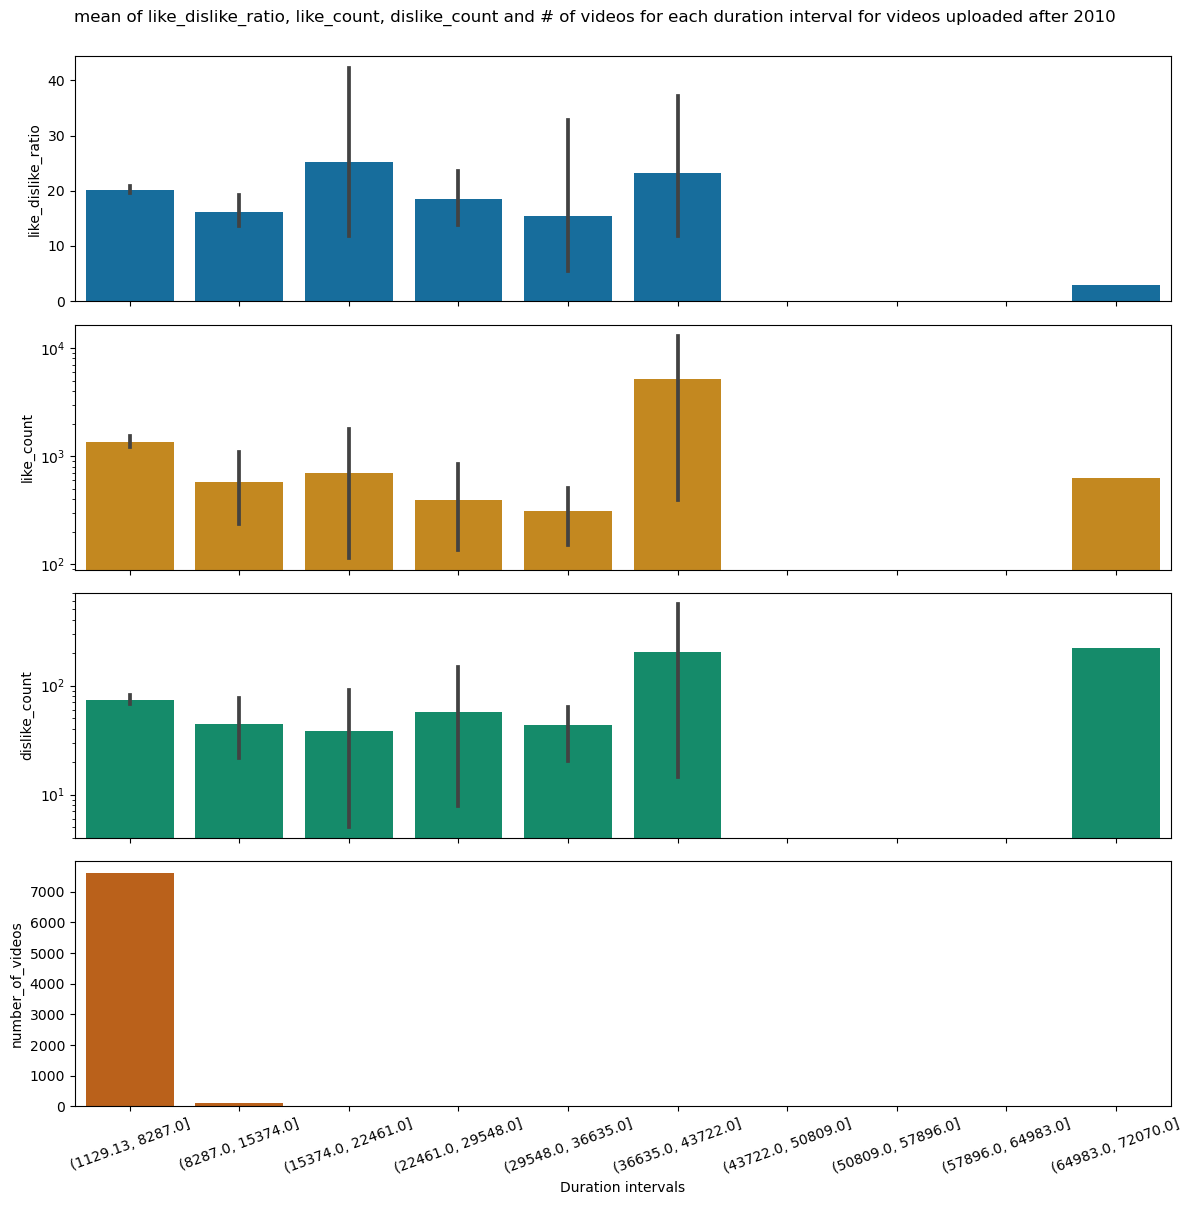

In [86]:
plot_statistics_across_duration_intervals(df_vd_tech_ratio_long, 2004)

We see from the moving average plot, that for videos of duration between 1200 seconds (=20 minutes) and 10000 seconds (~2.7 hours), the moving average of like to dislike ratio is fluctuating between 5 and 30 which is reasonable as there are many videos in that range (from long vlogs, to documentaries to football matches to movies...), as is shown by the 4th plot showing the number of videos per duration interval, and their quality differs. The interesting thing to notice here is that the moving average stagnates at 15 after the 2.7 hours mark, but we nevertheless see that the mean/average (not moving) is lower for long videos and this can be explained by the fact that the moving average is biased by previous values (which were high) as the window size is set to 500. The low like to dislike ratio for longer videos is indeed expected as first there aren't many videos of that type and they are normally boring, redundant/repetitive and thus get a low ratio. 

We also note that the best range for duration (in this case, taking the following 2 criteria into consideration: highest like-dislike ratio and probabitlity/feasabiltiy to provide a video of that length) is (1129, 8287] ~ (20 minutes, 2.3 hours] with a ratio of ~20.

Because it is a wide range, now let's break it down into smaller ranges and see what the videos are about in different duration ranges in the for the videos between 1129 and 8287 seconds.

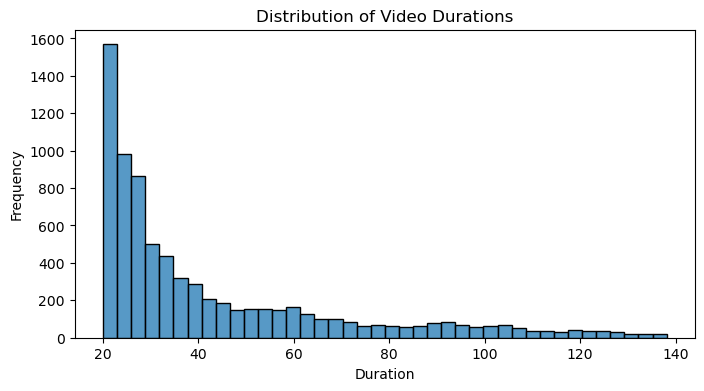

In [6]:
# filter the videos in the first range
df_vd_tech_long_most = df_vd_tech_long[(df_vd_tech_long.duration > 1129) & (df_vd_tech_long.duration <= 8287)]

# convert duration to minutes
df_vd_tech_long_most.duration = df_vd_tech_long_most.duration / 60

import ast
df_vd_tech_long_most['clean_title'] = df_vd_tech_long_most['clean_title'].apply(lambda x: ast.literal_eval(x))

# plot the histogram
plt.figure(figsize=(8, 4))
sns.histplot(df_vd_tech_long_most['duration'])
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Video Durations')
plt.show()

# Create a new column 'duration_intervals' containing the bin labels
bin_edges = [19, 40, 60, 200]
bin_labels = ['[19,40]', '[40,60]', '[60,200]']
df_vd_tech_long_most['duration_intervals'] = pd.cut(df_vd_tech_long_most['duration'], bins=bin_edges, labels=bin_labels, include_lowest=True)
df_vd_tech_long_most = df_vd_tech_long_most[['title','clean_title','duration_intervals','display_id']]

In [11]:
# turn the clean title into tokenize object
df_vd_tech_long_most['tokenized_title'] = df_vd_tech_long_most['clean_title'].apply(lambda x: word_tokenize(' '.join(x)))

# Function to get the most common pairs of words
def most_common_words(words, top_n=10):
    word_counter = Counter(words)
    return word_counter.most_common(top_n)

# Get the most common pairs of words for each duration_interval
for duration_interval in df_vd_tech_long_most['duration_intervals'].unique():
    subset = df_vd_tech_long_most[df_vd_tech_long_most['duration_intervals'] == duration_interval]
    all_words = [word for sublist in subset['tokenized_title'] for word in sublist]
    
    # Print the results
    print(f"Top 10 pairs of words for duration_interval {duration_interval}:")
    common_word_pairs = most_common_words(all_words)
    print(f"Word Pairs: {common_word_pairs}")
    print("\n")

Top 10 pairs of words for duration_interval [40,60]:
Word Pairs: [('review', 201), ('part', 147), ('day', 120), ('galaxy', 113), ('new', 104), ('google', 99), ('show', 98), ('android', 95), ('samsung', 93), ('iphone', 73)]


Top 10 pairs of words for duration_interval [60,200]:
Word Pairs: [('android', 297), ('weekly', 198), ('live', 168), ('day', 164), ('show', 160), ('macbreak', 151), ('part', 132), ('today', 120), ('galaxy', 119), ('io', 115)]


Top 10 pairs of words for duration_interval [19,40]:
Word Pairs: [('review', 1427), ('galaxy', 915), ('samsung', 803), ('unboxing', 630), ('part', 462), ('android', 406), ('note', 392), ('full', 375), ('pro', 371), ('first', 342)]




As we can see from above, for the videos between 20 and 60 minutes, the videos are still about the review of the tech products, but they are full and extended review video possibly broken into several parts, while the videos with duration above 1h are more from the release day live videos, that last for a couple of hours.

From our conducted analysis on videos' lengths, we finally come up with interesting insights to youtubers who want to move in the correct direction towards success and would like to know at what length should they cap their video. The best range is between 16 min and 2.7 hours, howerver longer videos are usually meant for live videos from conferences. The main takeway here is that we certainly want to avoid having really short videos in order to provide meaningful content to viewers and also avoid having really long videos so that we avoid boring them!

## Upload frequency

In [446]:
# read the timeseries dataset
tch_chan = df_tech_review_channels.copy()
tech_videos = df_tech_review_mt.copy()
timeseries = pd.read_csv(PATH_DF_TIMESERIES, sep="\t", compression="infer")

In this section we want to see the relationship between the frequency of releasing a video with the growth of number of subscribers. 

Here in those two plots, we divided the tech youtubers within bins using numerical tresholds.

Total number of videos available: 443780


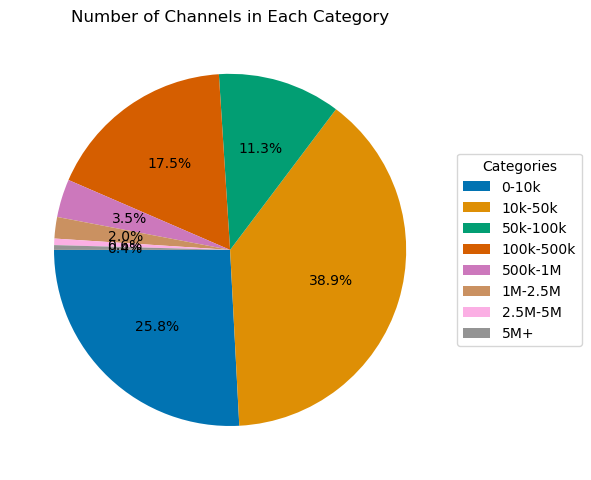

In [447]:
# Sort the DataFrame by channels then release date
tech_videos['upload_date'] = pd.to_datetime(tech_videos['upload_date'])
tech_videos = tech_videos.sort_values(['channel_id', 'upload_date'])

# filter time series such the it contains only the channels in tch_chan
ts_tech = timeseries[timeseries['channel'].isin(tch_chan['channel_id'])]
ts_tech = ts_tech.sort_values('datetime')

# filter the videos published during the period for which we have timeseries data available
tech_videos =tech_videos[(ts_tech['datetime'].max() >=tech_videos['upload_date']) & (tech_videos['upload_date']>= ts_tech['datetime'].min())]
tech_videos = tech_videos.sort_values('upload_date')

print("Total number of videos available:",tech_videos.shape[0])

# Create a new column to categorize subscribers into bins
bin_edges = [0 ,10000,  50000, 100000, 500000, 1000000, 2500000,  5000000, float('inf')]
bin_labels = ['0-10k', '10k-50k', '50k-100k', '100k-500k', '500k-1M', '1M-2.5M', '2.5M-5M', '5M+']

# Putting youtubers in categories depending on their subs_cat, cateogories must be between 1 and 8
ts_tech['Subs_Cat'] = pd.cut(ts_tech['subs'], bins=bin_edges, labels=bin_labels)
ts_tech['Rank_Cat'] = 8-ts_tech['Subs_Cat'].cat.codes # as we have 8 bins

# Plot the ratio of bins
sns.set_palette("colorblind")
channel_counts = ts_tech.groupby('Subs_Cat')['channel'].count()

plt.figure(figsize=(6, 6))
plt.pie(channel_counts, autopct='%1.1f%%', startangle=180)

plt.title('Number of Channels in Each Category')
plt.legend(channel_counts.index, title='Categories', bbox_to_anchor=(1, 0.5), loc="center left")
plt.tight_layout()
plt.show()

In [510]:
# Create a plotly visualization
labels = [str(cat) for cat in channel_counts.index]

fig = px.pie(
    names=labels,
    values=channel_counts.values,
    title='Number of Channels in Each Category'
)

# Add percentage labels
fig.update_traces(textinfo='percent+label', pull=[0.1] * len(labels))

# Customize layout
fig.update_layout(
    width = 700,
    height = 500,
    title_x = 0.5,
    legend_title='Categories',
    legend=dict(title=dict(text='Categories')),
)

# Save the plot to an HTML file
fig.write_html(PLOTS+'1_2_pie_1.html')

fig.show()

Now we want to see the correlation between the number of subscribers and the average monthly regularity of publishing a video, where the monthly regularity is defined as:

$$
\# \text{ videos} \cdot \log\left(1 + \frac{1}{\text{frequency}_{\text{std}}}\right)
$$

where ${\text{frequency} = \frac{1}{\text{delay}}}$, and _delay_ is time between publishing 2 consecutive videos in days.

This metric is a measure of how regular the youtuber is in terms of uploads, and we take the log to advantage youtubers who are more regular (low std)

Before all, let's observe the repartition of our set of study, most of the youtubers are small, indeed, almost 2 tech youtubers over 3  have between 0 and 50 000 subscribers, and only a small part of them has more than 500k subscribers. That is the reasong why we decided to split the data in categories to observe the relation between the regularity and the growth rate of those channels in different bins.

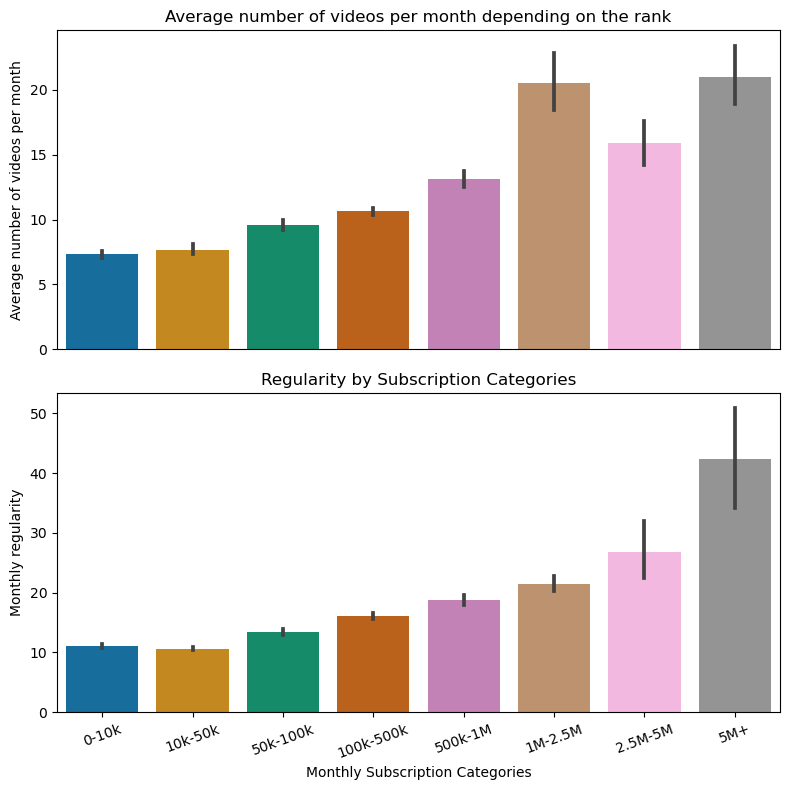

In [449]:
# get the delay
tech_mt_uf = tech_videos.copy()
tech_mt_uf['upload_date'] = pd.to_datetime(tech_mt_uf.upload_date)
tech_mt_uf.sort_values(by=['channel_id','upload_date'],ascending=True,inplace=True)
tech_mt_uf['delay'] = tech_mt_uf.upload_date - tech_mt_uf.shift(1).upload_date
first_upload = tech_mt_uf.groupby('channel_id',as_index=False)[['upload_date']].min()
first_upload['is_first'] = True
tech_df_upload_freq = pd.merge(tech_mt_uf,first_upload,on=['channel_id','upload_date'],how='left')
tech_df_upload_freq.is_first.fillna(False,inplace=True)
tech_df_upload_freq.loc[tech_df_upload_freq.is_first,'delay'] = pd.Timedelta(days=1)
#change the delay into number of days
tech_df_upload_freq.delay = (tech_df_upload_freq.delay / np.timedelta64(1, 'D')).astype(float)
#change all 0 by 1/(number of videos published in the same day)
tech_df_upload_freq.loc[tech_df_upload_freq.delay==0,'delay'] \
    = 1/tech_df_upload_freq.loc[tech_df_upload_freq.delay==0].groupby(['channel_id','upload_date']).delay.transform('count')

# get frequency
tech_df_upload_freq['upload_year'] = tech_df_upload_freq.upload_date.dt.year
tech_df_upload_freq['upload_month'] = tech_df_upload_freq.upload_date.dt.month
tech_df_upload_freq['upload_day'] = tech_df_upload_freq.upload_date.dt.day
# compute the standard deviation of the frequency of uploads per month (how much does the frequency of uploads vary within a month)
tech_df_upload_freq['frequency'] = 1/tech_df_upload_freq.delay
tech_df_upload_freq['frequency_monthly_std']= tech_df_upload_freq.groupby(['channel_id','upload_month', 'upload_year'])['frequency'].transform('std')
# Changing 0 std to the smallest non-zero value (to avoid division by 0)
tech_df_upload_freq['frequency_monthly_std'] = tech_df_upload_freq['frequency_monthly_std'].replace(0, np.nan)
smallest_nonzero = tech_df_upload_freq['frequency_monthly_std'].min()
tech_df_upload_freq['frequency_monthly_std'] = tech_df_upload_freq['frequency_monthly_std'].fillna(smallest_nonzero)
# compute the number of likes per views for each video, which is a metric of quality content
tech_df_upload_freq['likes_per_views'] = tech_df_upload_freq['like_count'] / tech_df_upload_freq['view_count']
tech_df_upload_freq['monthly_avg_likes_per_views'] = tech_df_upload_freq.groupby(['channel_id','upload_month', 'upload_year'])['likes_per_views'].transform('mean')
# compute the number of videos uploaded per month for each channel
tech_df_upload_freq['monthly_vids']=tech_df_upload_freq.groupby(['channel_id','upload_month', 'upload_year'])['display_id'].transform('count')
# select the columns we need
tch_monthly_data = tech_df_upload_freq[['channel_id','upload_year', 'upload_month','monthly_vids', 'frequency_monthly_std','monthly_avg_likes_per_views' ]]
tch_monthly_data.sort_values(by=['upload_year', 'upload_month','channel_id'],ascending=True,inplace=True)
tch_monthly_data.rename({'channel_id':'channel', 'upload_year':'year', 'upload_month':'month'},axis=1,inplace=True)

# get the channels monthly growth rate from time series data
ts_tech['datetime'] = pd.to_datetime(ts_tech["datetime"])
ts_tech['year'] = ts_tech['datetime'].dt.year
ts_tech['month'] = ts_tech['datetime'].dt.month
ts_tech['monthly_delta_subs']= ts_tech.groupby(['channel','year','month'])['delta_subs'].transform('sum')
ts_tech['monthly_subs']= ts_tech.groupby(['channel','year','month'])['subs'].transform('min')
# We assumed here that you never started with 0 subscribers, so we replaced the 0 by 1 , to avoid division by 0
ts_tech.loc[ts_tech.monthly_subs==0,'monthly_subs'] = 1
# compute the monthly growth rate of subscribers
ts_tech['monthly_subs_growth']= ts_tech['monthly_delta_subs']/ts_tech['monthly_subs']
ts_tech['monthly_subs_growth'].fillna(0,inplace=True)
# compute the category where the channel lies in each month, as some of them change categories
ts_tech['monthly_subs_cat']=ts_tech.groupby(['channel','year','month'])['Subs_Cat'].transform('max')
ts_tech['monthly_rank']= ts_tech.groupby(['channel','year','month'])['Rank_Cat'].transform('min')
# select the columns we need - drop duplicate, that are created because we have 4 datapoints (same) per month in timeseries
TS_Monthly = ts_tech[['channel','year','month','monthly_subs','monthly_subs_growth','monthly_delta_subs','monthly_subs_cat','monthly_rank']].drop_duplicates()

# merge the two dataframes and fill the NaN values with 0, as it refers to no video on a given month
mergedmonthly = pd.merge(TS_Monthly,tch_monthly_data,on=['channel','year','month'],how='left')
mergedmonthly['monthly_vids'].fillna(0,inplace=True)
mergedmonthly['frequency_monthly_std'].fillna(0,inplace=True)
mergedmonthly['monthly_avg_likes_per_views'].fillna(0,inplace=True)

# define the monthly regularity metric
mergedmonthly['monthly_regularity'] = mergedmonthly['monthly_vids'] * np.log(1 + 1 / mergedmonthly['frequency_monthly_std'])
mergedmonthly['monthly_regularity'].fillna(0,inplace=True)

# let's leave only the months and years where all categories are present (from october 2016):
mergedmonthly['date'] = pd.to_datetime(mergedmonthly['year'].astype(str) + '-' + mergedmonthly['month'].astype(str))
mergedmonthly = mergedmonthly[mergedmonthly['date'] > pd.to_datetime('2016-09')].drop_duplicates()

# plots
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(8,8))
sns.barplot(data=mergedmonthly, x='monthly_subs_cat', y='monthly_vids', palette='colorblind', ax=axs[0])
sns.barplot(data=mergedmonthly, x='monthly_subs_cat', y='monthly_regularity', palette='colorblind', ax=axs[1]) 
axs[0].set(title='Average number of videos per month depending on the rank',xlabel=None,xticks=[],ylabel='Average number of videos per month')
axs[1].set(title='Regularity by Subscription Categories',xlabel='Monthly Subscription Categories',ylabel='Monthly regularity')
axs[0].tick_params(axis='x',rotation=20)
axs[1].tick_params(axis='x',rotation=20)
plt.tight_layout()
plt.show()

In [509]:
# Create a plotly visualization
mergedmonthly_plot = mergedmonthly.copy()
mergedmonthly_plot['monthly_subs_cat'] = mergedmonthly_plot['monthly_subs_cat'].astype(str)

# Calculate mean and confidence intervals
mean_ci_data = mergedmonthly_plot.groupby(['monthly_subs_cat','monthly_rank'])['monthly_regularity'].agg(['mean', 'sem']).reset_index()
mean_ci_data['ci_low'] = mean_ci_data['mean'] - 1.96 * mean_ci_data['sem']
mean_ci_data['ci_high'] = mean_ci_data['mean'] + 1.96 * mean_ci_data['sem']
mean_ci_data.sort_values(by='monthly_rank',ascending=False)

# Create a bar plot with error bars using Plotly Express
fig = px.bar(
    mean_ci_data,
    x='monthly_subs_cat',
    y='mean',
    error_y='sem',
    title='Regularity Subscription Categories',
    labels={'monthly_subs_cat': 'Monthly Subscription Categories', 'mean': 'Average Monthly Regularity'},
    category_orders={"monthly_subs_cat": mergedmonthly_plot.sort_values('monthly_rank',ascending=False)['monthly_subs_cat'].unique().tolist()}
)

# Customize layout
fig.update_layout(
    width = 700,
    height = 500,
    title_x = 0.5,
    xaxis=dict(tickangle=20),
    yaxis_title='Mean Regularity'
)

# Save the plot to an HTML file
fig.write_html(PLOTS+'1_2_bars_1.html')

fig.show()

The main observation that we can do in this case, is that on average, the higher the category (and thus the number of subscribers), the higher the regularity is, and confidence intervals are not overlapping anywhere but in within the first two categories that represent relatively "small" youtubers.

Now, we want to plot the moving average regularity and channels' growth to see if we can spot some clear relation between them:

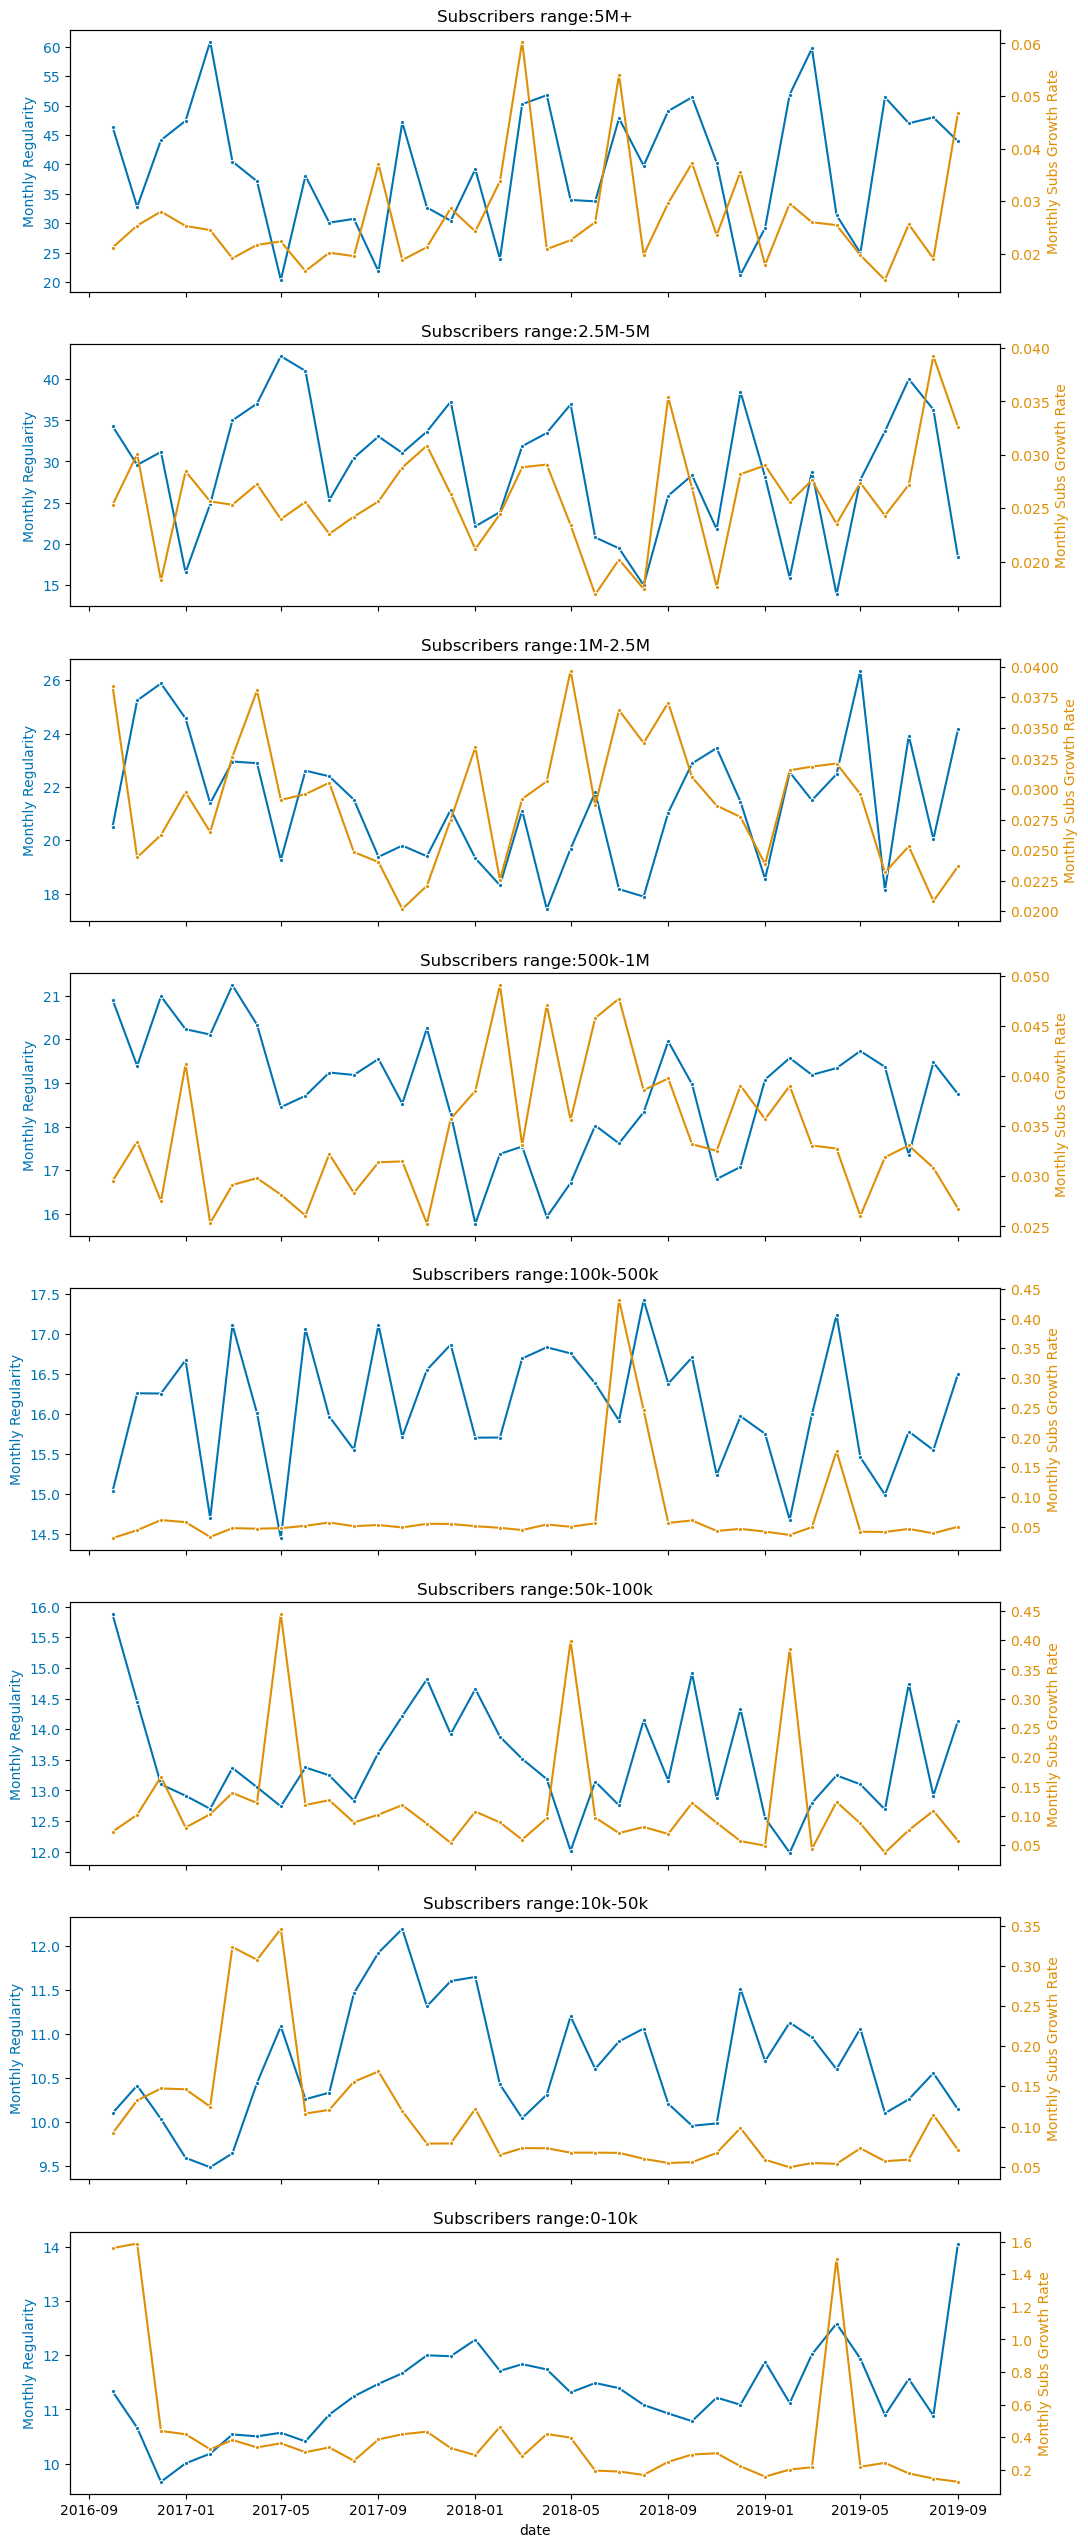

In [507]:
# prepare the dataset to plot the moving averages
monthly_avg  = mergedmonthly.groupby(['date', 'monthly_rank']).agg({
    'monthly_subs_cat':'min',
    'monthly_subs_growth': 'mean',
    'monthly_regularity': 'mean',
    'monthly_vids':'mean',
    'channel':'count'
}).reset_index()
monthly_avg.sort_values(by='monthly_rank',inplace=True)

# Get unique categories
categories = monthly_avg['monthly_subs_cat'].unique()

# Plot
palette = sns.color_palette("colorblind", n_colors=2)
fig, axes = plt.subplots(nrows=len(categories), ncols=1, figsize=(12, 32), sharex=True)

for i, category in enumerate(categories):
    # Filter data for the current category
    category_data = monthly_avg[monthly_avg['monthly_subs_cat'] == category]

    # Apply moving averages to number of videos per month
    category_data['monthly_regularity_ma'] = category_data['monthly_regularity'].rolling(window=3, min_periods=1).mean()
    # Apply moving averages to monthly subscription growth rate
    category_data['monthly_subs_growth_ma'] = category_data['monthly_subs_growth'].rolling(window=3, min_periods=1).mean()

    # Plotting number of videos per month with moving averages and different color
    axes[i].set_title(f'Subscribers range:{str(category)}')
    ax1 = axes[i]
    ax1 = sns.lineplot(data=category_data, x='date', y='monthly_regularity_ma', ax=ax1, marker='.', estimator=None, color=palette[0])
    ax1.set_ylabel('Monthly Regularity', color=palette[0])
    ax1.tick_params(axis='y', labelcolor=palette[0])

    # Create a second y-axis for monthly subscription growth rate
    ax2 = ax1.twinx()
    ax2 = sns.lineplot(data=category_data, x='date', y='monthly_subs_growth_ma', ax=ax2, marker='.', estimator=None, color=palette[1])
    ax2.set_ylabel('Monthly Subs Growth Rate', color=palette[1])
    ax2.tick_params(axis='y', labelcolor=palette[1])

plt.show()

In [508]:
# Create a plotly visualization
colors = sns.color_palette("colorblind", n_colors=2)
colors_hex = [f"#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}" for r, g, b in colors]

for i, category in enumerate(categories):
    # Filter data for the current category
    category_data = monthly_avg[monthly_avg['monthly_subs_cat'] == category]

    # Apply moving averages to number of videos per month
    category_data['monthly_regularity_ma'] = category_data['monthly_regularity'].rolling(window=3, min_periods=1).mean()
    # Apply moving averages to monthly subscription growth rate
    category_data['monthly_subs_growth_ma'] = category_data['monthly_subs_growth'].rolling(window=3, min_periods=1).mean()

    # Assuming category_data is a pandas DataFrame
    category_data = category_data.sort_values(by='date')

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces for the first y-axis (left)
    trace_regularity = go.Scatter(x=category_data['date'], y=category_data['monthly_regularity_ma'], name='Monthly Regularity', line=dict(color=colors_hex[0]))
    fig.add_trace(trace_regularity, secondary_y=False)

    # Add traces for the second y-axis (right)
    trace_subs_growth = go.Scatter(x=category_data['date'], y=category_data['monthly_subs_growth_ma'], name='Monthly Subs Growth Rate', line=dict(color=colors_hex[1]))
    fig.add_trace(trace_subs_growth, secondary_y=True)

    # Update layout
    fig.update_layout(
        title=f'Subscribers range: {str(category)}',
        title_x=0.5,
        xaxis_title='Date',
        yaxis_title='Monthly Regularity',
        yaxis2_title='Monthly Subs Growth Rate',
        width=700,
        height=400
    )

    # Remove legend
    fig.update_layout(showlegend=False)

    # Color y-axis labels
    fig.update_yaxes(title_font_color=trace_regularity.line.color, secondary_y=False)
    fig.update_yaxes(title_font_color=trace_subs_growth.line.color, secondary_y=True)

    # Save the plot to an HTML file
    fig.write_html(PLOTS+f'1_2_regularity_lines{str(category)}.html')

    fig.show()


While observing those plots, we can globally observe a similar trend between the regularity of youtubers and their growth rate within each month, except for some groups, s.t. the youtubers that have between 500 000 and 1 000 000 subscribers.

For youtubers that have more than 5 000 0000 subscribers, we can observe that the growth rate fluctuates a lot, as they are only few youtubers within that category so it's more volatile, but the trend is in overall similar to the one of regularity.

Moreover, we can also observe a kind of pattern related to all categories (except between 500k and 1M), and this is that we observe some jumps in terms of regularity during the end of each year, which coincides with the periods of christmas, thanksgivng , black friday and the relases of video games and cellphones (like Iphones), but it is a different discussion that we will go deeper in section 3. 

Now, let's focus more on the group 4 (500k-1M subs):
- We first select all the channels that have been in this range at some point of time during this 3 years of period (2016-2019), and then see which groups they have ended up in 2019, just to have an idea of how channels move between the groups.

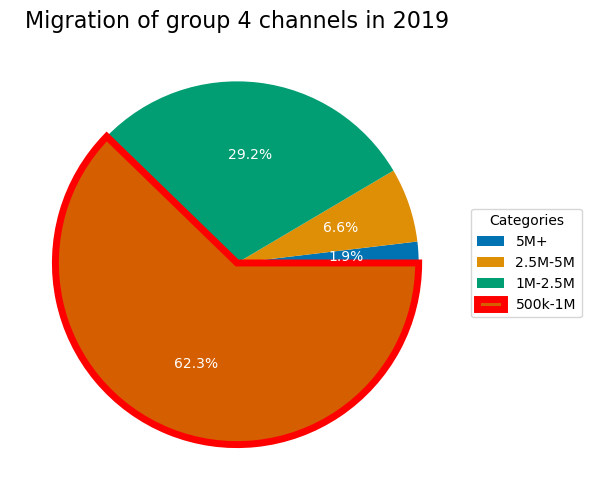

In [453]:
# filter only those channels that were in category 4 (500k-1M) at some point during the period
channel4 = mergedmonthly[(mergedmonthly['monthly_rank'] == 4)].channel.unique()
mergedmonthly4 = mergedmonthly[mergedmonthly.channel.isin(channel4)]

channels4_avg  = mergedmonthly4.groupby(['date','monthly_rank']).agg({
    'monthly_subs_cat':'min',
    'monthly_subs_growth': 'mean',
    'monthly_regularity': 'mean',
    'channel':'count',
    'monthly_vids':'mean'
}).reset_index()

pieplot = channels4_avg[channels4_avg['date'] == pd.to_datetime('2019-09-01')][['monthly_subs_cat','channel']].reset_index(drop=True)
pieplot.monthly_subs_cat = pieplot.monthly_subs_cat.astype(str)

# Create the pie chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    pieplot['channel'],
    labels=pieplot['monthly_subs_cat'],
    autopct='%1.1f%%',
    textprops=dict(color="w")
)

# Highlight the specific category
highlight_index = pieplot[pieplot['monthly_subs_cat'] == '500k-1M'].index[0]
wedges[highlight_index].set_edgecolor('red')
wedges[highlight_index].set_linewidth(5)

# Customize chart properties
plt.title("Migration of group 4 channels in 2019", fontsize=16)
plt.legend(pieplot['monthly_subs_cat'], title='Categories', bbox_to_anchor=(1, 0.5), loc="center left")

plt.tight_layout()
plt.show()


In [480]:
# Create a plotly visualization
fig = go.Figure()

fig.add_trace(go.Pie(
    labels=pieplot['monthly_subs_cat'],
    values=pieplot['channel'],
    hole=0.3,
    marker=dict(colors=px.colors.qualitative.Set3, line=dict(color='#000000', width=2)),
))

# Highlight the specific category
highlight_index = pieplot[pieplot['monthly_subs_cat'] == '500k-1M'].index[0]
fig.update_traces(
    marker=dict(line=dict(color=['red' if i == highlight_index else '#000000' for i in range(len(pieplot))], width=[5 if i == highlight_index else 2 for i in range(len(pieplot))]))
)
fig.update_traces(textinfo='percent+label', pull=[0.05] * pieplot['monthly_subs_cat'].nunique())

# Customize chart properties
fig.update_layout(
    width=700,
    height=500,
    title="Migration of group 4 channels in 2019",
    legend=dict(title='Categories', x=1.1, y=0.5),
    title_x=0.5,
    annotations=[
        dict(
            text=f'Total Number of Channels: {pieplot.channel.sum()}',
            x=0.5,
            y=-0.15,
            showarrow=False,
            font=dict(size=15,color='blue'),
        )
    ],
)

# Save the plot to an HTML file
fig.write_html(PLOTS+f'1_2_pie_2.html')

fig.show()


What we can observe here is that within people that were in group 4, ~62% stayed in its group, and the reset moved to the higher groups, as they gained more subscribers. That means that a lot of youtubers changed categories and improved over time.

Now, let us see if the above trends of channels' growth and regularity rates correspond with some noticible difference in the number of channels within the group. More preciesly, below we plot the trends with:
- new 7 or more channels upgrade to the group 4 - green vertical line
- new 2 or more channels upgrade to the higher groups - red vertical line

Average number of channels in this group: 41


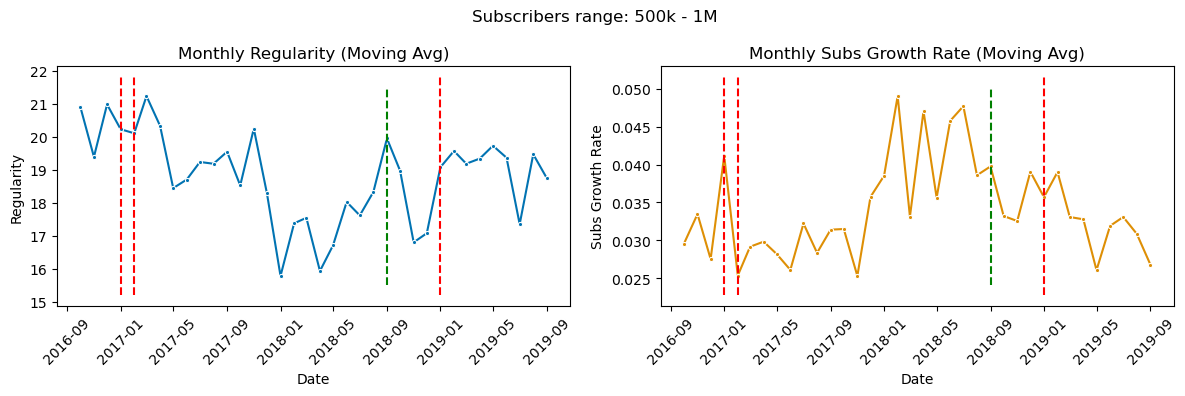

In [405]:
# Create a color palette for different categories
palette = sns.color_palette("colorblind", len(categories))

# Create 2x2 subplots (2categories, 2 plots each)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Filter data for the current category
category_data = monthly_avg[monthly_avg['monthly_rank'] == 4]
print('Average number of channels in this group:',int(category_data.channel.mean()))

# Apply moving averages to number of videos per month
category_data['monthly_regularity_ma'] = category_data['monthly_regularity'].rolling(window=3, min_periods=1).mean()

# Plotting number of videos per month with moving averages and different color
sns.lineplot(data=category_data, x='date', y='monthly_regularity_ma', ax=axes[0], marker='.', estimator=None, color=palette[0])
axes[0].set_title(f'Monthly Regularity (Moving Avg)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Regularity')
axes[0].tick_params(axis='x', rotation=45)

# Apply moving averages to monthly subscription growth rate
category_data['monthly_subs_growth_ma'] = category_data['monthly_subs_growth'].rolling(window=3, min_periods=1).mean()

# Plotting monthly subscription growth rate with moving averages and different color
sns.lineplot(data=category_data, x='date', y='monthly_subs_growth_ma', ax=axes[1], marker='.', estimator=None, color=palette[1])
axes[1].set_title(f'Monthly Subs Growth Rate (Moving Avg)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Subs Growth Rate')
axes[1].tick_params(axis='x', rotation=45)

# Plotting vertical lines at the points where the number channels within a cateory increased by 7 or more or decreased by 2 or more
category_data.sort_values(by='date',inplace=True,ascending=True)
increase_points = category_data[category_data['channel'].diff()>=(7)]

category_data.sort_values(by='date',inplace=True,ascending=False)
decreasing_points = category_data[category_data['channel'].diff()>=(2)]

# Plot vertical lines at those points
axes[0].vlines(x=increase_points['date'].values, ymin=axes[0].get_ylim()[0], ymax=axes[0].get_ylim()[1], color='green', linestyles='dashed')
axes[0].vlines(x=decreasing_points['date'].values, ymin=axes[0].get_ylim()[0], ymax=axes[0].get_ylim()[1], color='red', linestyles='dashed')
axes[1].vlines(x=increase_points['date'].values, ymin=axes[1].get_ylim()[0], ymax=axes[1].get_ylim()[1], color='green', linestyles='dashed')
axes[1].vlines(x=decreasing_points['date'].values, ymin=axes[1].get_ylim()[0], ymax=axes[1].get_ylim()[1], color='red', linestyles='dashed')

plt.suptitle('Subscribers range: 500k - 1M')
plt.tight_layout()
plt.show()

In [506]:
# Create a plotly visualization

# Filter data for the group 4
category_data = monthly_avg[monthly_avg['monthly_rank'] == 4]

# Apply moving averages to number of videos per month
category_data['monthly_regularity_ma'] = category_data['monthly_regularity'].rolling(window=3, min_periods=1).mean()
# Apply moving averages to monthly subscription growth rate
category_data['monthly_subs_growth_ma'] = category_data['monthly_subs_growth'].rolling(window=3, min_periods=1).mean()

# Assuming category_data is a pandas DataFrame
category_data = category_data.sort_values(by='date')

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces for the first y-axis (left)
trace_regularity = go.Scatter(x=category_data['date'], y=category_data['monthly_regularity_ma'], name='Monthly Regularity', line=dict(color=colors_hex[0]))
fig.add_trace(trace_regularity, secondary_y=False)

# Add traces for the second y-axis (right)
trace_subs_growth = go.Scatter(x=category_data['date'], y=category_data['monthly_subs_growth_ma'], name='Monthly Subs Growth Rate', line=dict(color=colors_hex[1]))
fig.add_trace(trace_subs_growth, secondary_y=True)

# Add vertical lines for joined channels
category_data.sort_values(by='date',inplace=True,ascending=True)
increase_points = category_data[category_data['channel'].diff()>=(7)]

for date in increase_points['date']:
    fig.add_shape(
        go.layout.Shape(
            type="line",
            x0=date,
            x1=date,
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="green", width=2, dash="dash")
        )
    )

# Add vertical lines for left channels
category_data.sort_values(by='date',inplace=True,ascending=False)
decreasing_points = category_data[category_data['channel'].diff()>=(2)]

for date in decreasing_points['date']:
    fig.add_shape(
        go.layout.Shape(
            type="line",
            x0=date,
            x1=date,
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="red", width=2, dash="dash")
        )
    )

fig.add_trace(go.Scatter(x=[None], y=[None], line=dict(color="green", width=2, dash="dash"), name=">7 channels joined"))
fig.add_trace(go.Scatter(x=[None], y=[None], line=dict(color="red", width=2, dash="dash"), name=">2 channels left"))

# Update layout
fig.update_layout(
    title=f'Subscribers range: {str(category)}',
    title_x=0.5,
    xaxis_title='Date',
    yaxis_title='Monthly Regularity',
    yaxis2_title='Monthly Subs Growth Rate',
    width=700,
    height=400,
    legend=dict(
        x=0.85, 
        y=1.45,
        traceorder="reversed",
        font=dict(family="sans-serif", size=10, color="black"),
    ),
)

# Color y-axis labels
fig.update_yaxes(title_font_color=trace_regularity.line.color, secondary_y=False)
fig.update_yaxes(title_font_color=trace_subs_growth.line.color, secondary_y=True)

# Save the plot to an HTML file
fig.write_html(PLOTS+f'1_2_regularity_lines0-10k_vertical_lines.html')

fig.show()

We observe that usually the trends see a notcible change followed by the joining or leaving of some group of channels to the groups, i.e. average growth rate observed a massive drop when the categories know an increase in the number of youtubers in which they are (2018-09), and this probably because newly arrived youtubers do not have the same growth rate than those already present, even though they have a similar regularity.

Now let's see in general how often we should publish a video, and how it changes when we switch between the groups.

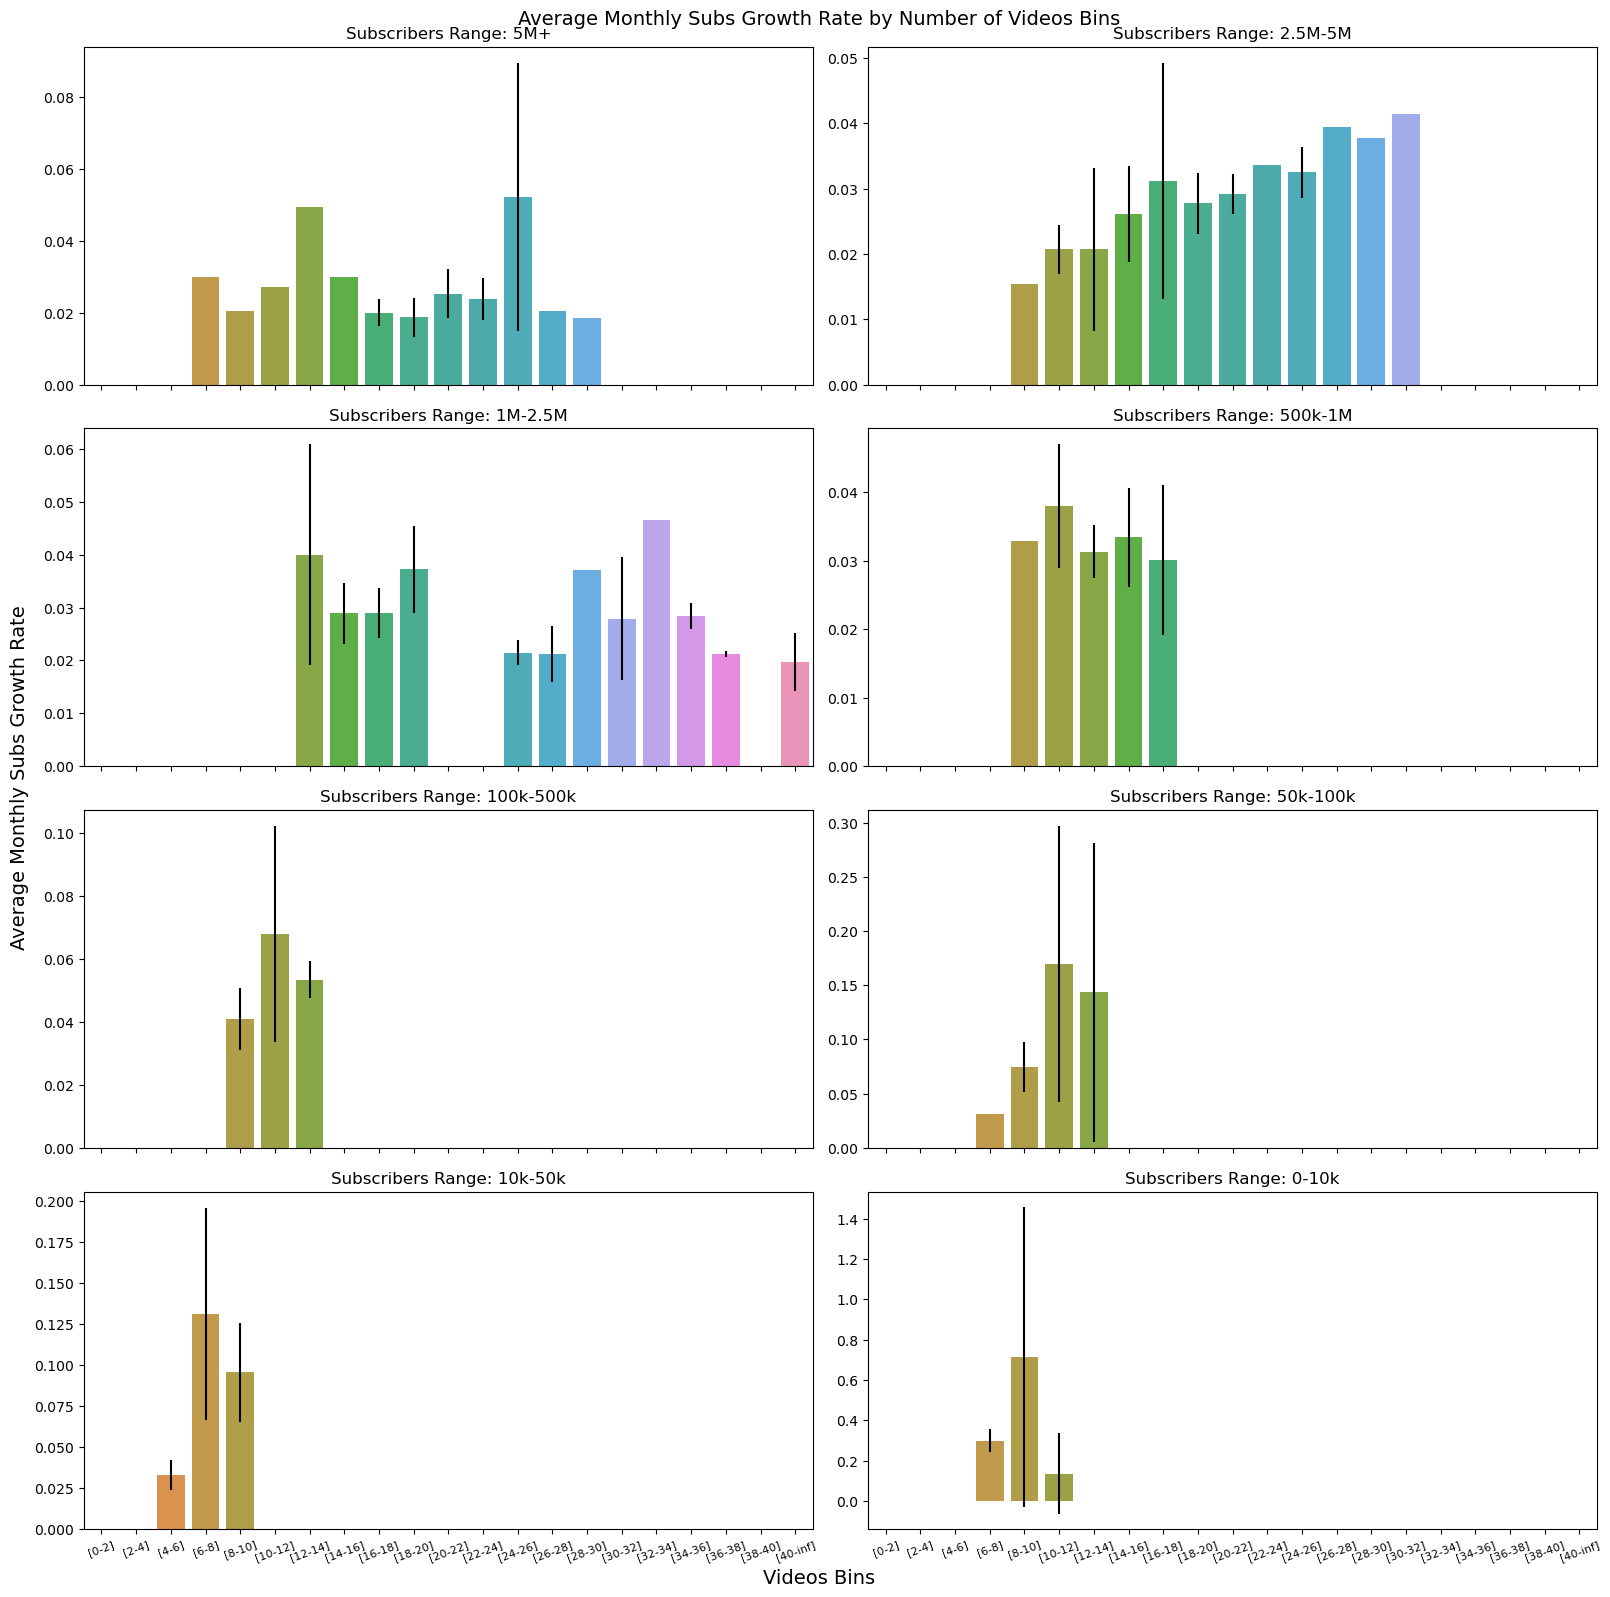

In [601]:
bins = list(range(0, 40, 2))
bins.append(40)
bins.append(float('inf'))
bin_labels = [f'[{bins[i]}-{bins[i+1]}]' for i in range(len(bins)-1)]

palette = sns.color_palette("colorblind", n_colors=2)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16), sharex=True)

fig.text(0.5, 0, 'Videos Bins', ha='center', va='center', fontsize=14)
fig.text(0, 0.5, 'Average Monthly Subs Growth Rate', ha='center', va='center', rotation='vertical', fontsize=14)

for i, category in enumerate(categories):
    # Filter data for the current category
    category_data = monthly_avg[monthly_avg['monthly_subs_cat'] == category]
    category_data['monthly_vids_bins'] = pd.cut(category_data['monthly_vids'], bins=bins, labels=bin_labels)
    
    # Calculate the mean and confidence intervals for each regularity bin
    result = category_data.groupby('monthly_vids_bins')['monthly_subs_growth'].agg(['mean', 'std'])
    result['CI'] = 1.96 * (result['std'] / np.sqrt(category_data.groupby('monthly_vids_bins')['monthly_subs_growth'].count()))

    # Plotting with error bars (confidence intervals)
    sns.barplot(x=result.index, y=result['mean'], yerr=result['CI'], capsize=0.1, ax=axes[i // 2][i % 2])
    axes[i // 2][i % 2].set_title(f'Subscribers Range: {category}')
    axes[i // 2][i % 2].set_ylabel('')
    axes[i // 2][i % 2].set_xlabel('')
    axes[i // 2][i % 2].tick_params(axis='x', rotation=20, labelsize=8)

plt.suptitle('Average Monthly Subs Growth Rate by Number of Videos Bins', fontsize=14)
plt.tight_layout()
plt.show()

In [622]:
# Create a plotly visualization
category_data = monthly_avg.copy()
category_data['monthly_vids_bins'] = pd.cut(category_data['monthly_vids'], bins=bins, labels=bin_labels)

# Calculate the mean and confidence intervals for each regularity bin
result = category_data.groupby(['monthly_subs_cat','monthly_vids_bins'])['monthly_subs_growth'].agg(['mean', 'std'])
result['CI'] = 1.96 * (result['std'] / np.sqrt(category_data.groupby('monthly_vids_bins')['monthly_subs_growth'].count()))
result.reset_index(inplace=True)
result.monthly_vids_bins = result.monthly_vids_bins.astype(str)

# Plotly Express bar plot with animation
fig = px.bar(
    result,
    x='monthly_vids_bins',
    y='mean',
    error_y='CI',
    animation_frame='monthly_subs_cat',
    labels={'monthly_subs_growth': 'Average Monthly Subs Growth Rate', 'monthly_vids_bins': 'Number of Videos Bins'},
    height=500,
    width=600,
)

# Customize layout
fig.update_layout(
    title='Average Monthly Subs Growth Rate by Number of Videos Bins',
    title_x=0.5,
    yaxis_title='Average Monthly Subs Growth Rate',
    xaxis_title='Monthly Number of Videos',
    showlegend=False,
    width=700,
    height=500,
    font=dict(size=10),
)

# Save the plot to an HTML file
fig.write_html(PLOTS+f'1_2_bars_animation.html')

fig.show()


The major think to remark here is that even the regularity (number of videos in this case) and its influence on the channel's growth is changing depending on the subscription range. For example, for the small YouTubers, 8-10 videos per month seems to be helping the channel to grow more, while for big YouTubers, publishing a video every single day seems to have a higher influence.

We can thus conclude that even for youtubers that have between 500k and 2.5M subscribers, being regular (almost 1 video per week) is a huge plus if you want to grow fastly.

And more generally, being regular , in terms of number of videos released each month, but also in terms of low volatility, helps you to grow faster as you tend to build viewers loyalty.

## Review product types

In this section, we are going to focus on the types of review products. More specifically, we first classify videos into one of the 7 types we are analysing, depending on some defined keywords that are relevant to these tech types. Then for each channel, we are calculating the percentage of each product type videos. Let's firts see which product types are more common among the YouTubers, then we will answer the following sub-questions:

- What range of products types should be covered?
- What product categories have higher influence on the channels growth?
- Which product categories attract more viewers?

In [627]:
# Define the filename for the JSON file
keywords_path = DIR + '\\product_keywords.json'

# Read the keywords from the JSON file
with open(keywords_path, 'r') as file:
    keywords = json.load(file)

# get the product types
products = list(keywords.keys())
print(products)

['laptop', 'phone', 'camera', 'headphone', 'smart_watches', 'tablet', 'desktop_setup']


In [629]:
tech_df_mt = df_tech_review_mt.copy()

# 2 videos are missing title, so we ignore them
tech_df_mt = tech_df_mt[tech_df_mt.title.notna()]

# classify the video into laptop, phone, camera
tech_df_mt['product_category'] = tech_df_mt.title.apply(lambda title: classify_product(title.lower(), keywords))

# drop the videos that are not classified as either one of the product types
tech_df_prd = tech_df_mt[tech_df_mt.product_category.notna()]
print("Number of videos in metadata: ", tech_df_mt.shape[0])
print("Number of videos about either of the products: ", tech_df_prd.shape[0])

# get the percentage of videos in each categorie per channel
tech_df_prd_count = tech_df_prd.groupby(['channel_id','product_category'],as_index=False)[['display_id']].count().pivot(index='channel_id',columns='product_category',values='display_id').fillna(0)
tech_df_prd_perc = tech_df_prd_count.divide(tech_df_prd_count.sum(axis=1),axis=0)
display(tech_df_prd_perc.sample(5))

Number of videos in metadata:  740016
Number of videos about either of the products:  516660


product_category,camera,desktop_setup,headphone,laptop,phone,smart_watches,tablet
channel_id,,,,,,,
UCUcsfHbh21DeQ_6ZNduvaiQ,0.000000,0.454545,0.090909,0.436364,0.018182,0.000000,0.000000
UCspZF0GE749o4U0upQuHcAQ,0.072464,0.072464,0.028986,0.072464,0.753623,0.000000,0.000000
UCVlMUh4WsDQvOxCJJXmWwdw,0.029921,0.064567,0.059843,0.258268,0.537008,0.014173,0.036220
UCvOU-zTlankT-JjN3ZzvuKA,0.076294,0.095368,0.580381,0.013624,0.228883,0.000000,0.005450
UCSsNUXKG2gjqosl3kW62HwQ,0.078014,0.168186,0.343465,0.049645,0.290780,0.021277,0.048632


Let's see in what categories more successful YouTubers tend to produce tech review videos by plotting the moving average (with window size of 50) of product type percentages over the rank of the YouTubers.

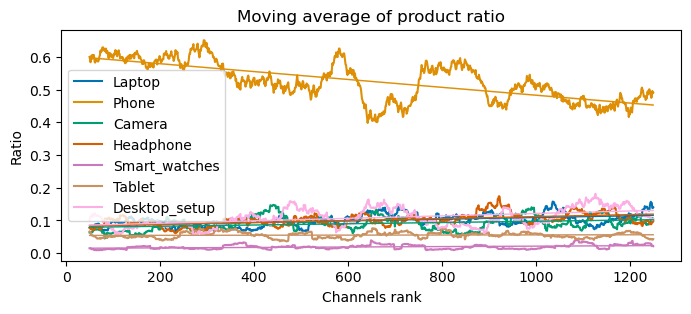

In [630]:
# define a new rank to the channels depending on its number of subscribers
df_tech_review_channels['new_rank'] = pd.Series(range(1, df_tech_review_channels.shape[0]+1))

# flag the channels with wide/narrow range of tech products to be used later
tech_df_prd_perc.loc[tech_df_prd_perc.apply(lambda df: any(df[p] > 0.8 for p in products), axis=1),'wide_range'] = 0
tech_df_prd_perc['wide_range'].fillna(1, inplace=True)

# merge
channels_rank = pd.merge(df_tech_review_channels[['subscribers_cc','channel_id','new_rank']],tech_df_prd_perc,on='channel_id',how='right').sort_values(by='new_rank',ascending=True).reset_index(drop=True)

# moving average of category percentage per rank
colors = sns.color_palette("colorblind",len(products))
plt.figure(figsize=(8,3))

# plot moving average
for idx,product in enumerate(products):
    ax = sns.lineplot(x=channels_rank['new_rank'], y=channels_rank[product].rolling(50).mean(), label=product.capitalize(),color=colors[idx])

# Add regression lines
for idx,product in enumerate(products):
    sns.regplot(x=channels_rank['new_rank'], y=channels_rank[product].rolling(50).mean(), scatter=False, ax=ax, color=colors[idx], line_kws={'linewidth': 1})

ax.set(title='Moving average of product ratio', xlabel='Channels rank', ylabel='Ratio')
plt.legend()
plt.show()


As we can see, most channels tend to focus on phones. It just means phones are a common topic to focus on, but we still need to see (in the next sub-section) how it actually influences the channel's growth.

Below, we analyze the effect of covering wider/narrow range of products on the number of subscribers. But before that we want to balance the dataset on some metrics, namely average duration of videos per channel, and the delay in time between publishing 2 sequential videos. Below, we compute these metrices per video, and compute their micro averages.

### What range of products types should be covered?

In [631]:
# define average upload frequency per channel
tech_mt_uf = df_tech_review_mt.copy()
tech_mt_uf['upload_date'] = pd.to_datetime(tech_mt_uf.upload_date)
tech_mt_uf.sort_values(by=['channel_id','upload_date'],ascending=True,inplace=True)
tech_mt_uf['delay'] = tech_mt_uf.upload_date - tech_mt_uf.shift(1).upload_date
# set all first uploads to 0
first_upload = tech_mt_uf.groupby('channel_id',as_index=False)[['upload_date']].min()
first_upload['is_first'] = True
tech_df_upload_freq = pd.merge(tech_mt_uf,first_upload,on=['channel_id','upload_date'],how='left')
tech_df_upload_freq.is_first.fillna(False,inplace=True)
tech_df_upload_freq.loc[tech_df_upload_freq.is_first,'delay'] = pd.Timedelta(seconds=0)
tech_df_upload_freq['upload_year'] = tech_df_upload_freq.upload_date.dt.year
tech_df_upload_freq['upload_month'] = tech_df_upload_freq.upload_date.dt.month
tech_df_avg = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['delay']].mean().groupby(['channel_id','upload_year'],as_index=False)[['delay']].mean().groupby(['channel_id'],as_index=False)[['delay']].mean()
tech_df_avg.rename({'delay':'avg_delay'},axis=1,inplace=True)
tech_df_avg.avg_delay = (tech_df_avg.avg_delay / np.timedelta64(1, 'D')).astype(float)

# define average duration
tech_df_avg_dur = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['duration']].mean().groupby(['channel_id','upload_year'],as_index=False)[['duration']].mean().groupby(['channel_id'],as_index=False)[['duration']].mean()
tech_df_avg_dur.rename({'duration':'avg_duration'},axis=1,inplace=True)

# get the total number of views per channel
view_sum = df_tech_review_mt.groupby('channel_id',as_index=False)[['view_count']].sum().rename({'view_count':'view_sum'},axis=1)

# define dataframe for observational study
df_obs = pd.merge(df_tech_review_channels[['channel_id','subscribers_cc']],tech_df_avg_dur,on='channel_id',how='left')
df_obs = pd.merge(df_obs,tech_df_avg,on='channel_id',how='left')
df_obs = pd.merge(df_obs,channels_rank[['channel_id','wide_range']],on='channel_id',how='right')
df_obs = pd.merge(df_obs,view_sum,on='channel_id',how='left')
df_obs.loc[df_obs['wide_range'],'wide_range'] = 1
df_obs.loc[df_obs['wide_range'] != 1,'wide_range'] = 0
df_obs['wide_range'] = df_obs['wide_range'].astype(int)
print("# of 'wide' channels: {}".format(df_obs.wide_range.sum()))
print("# of 'narrow' channels: {}".format(df_obs.wide_range.count() - df_obs.wide_range.sum()))
display(df_obs.sample(5))

# of 'wide' channels: 958
# of 'narrow' channels: 290


,channel_id,subscribers_cc,avg_duration,avg_delay,wide_range,view_sum
991,UCdHqjtlp8HtKFtQXDe3BZ4w,19400,212.245703,7.251987,1,4200424.0
466,UCVufJpooxaYTboekTMo9Djw,104000,533.977158,4.018111,0,33622895.0
1034,UCVSILwiyPSdVlOjdMAXiguw,18912,157.195185,73.291181,0,332563.0
445,UCKcFpMSH5prRLDhRcd6UJrg,111000,363.207970,4.222661,1,10132596.0
576,UCNZdyOVPOqeeYhSbPOQJkYA,69500,216.587342,10.780194,0,9233050.0


Here we balance the two groups on the above-defined metrices, and see the distribution of the number of subscribers and total views of 2 groups.

Optimization terminated successfully.
         Current function value: 0.537558
         Iterations 6


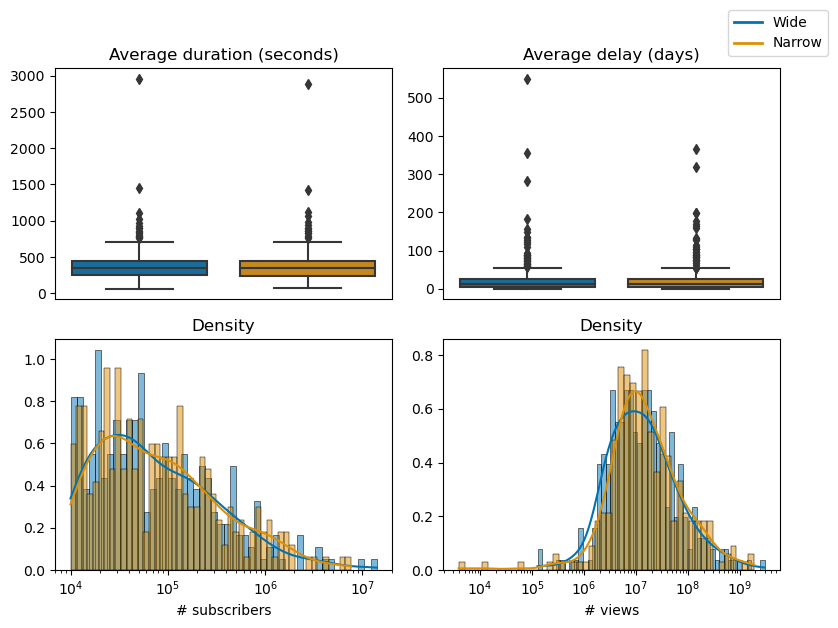

In [632]:
# balance the treat and control groups
match_idx = balance_data(df=df_obs,treat_column='wide_range',continuous_features=['avg_duration','avg_delay'])
df_obs_matched = df_obs.iloc[match_idx]

# plot
colors = sns.color_palette("colorblind",2)
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(8,6))

sns.boxplot(y=df_obs_matched['avg_duration'],x=df_obs_matched['wide_range'],ax=axes[0][0],palette=colors)
sns.boxplot(y=df_obs_matched['avg_delay'],x=df_obs_matched['wide_range'],ax=axes[0][1],palette=colors)
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 1]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[1][0],color=colors[0])
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 0]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[1][0],color=colors[1])
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 1]['view_sum'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[1][1],color=colors[0])
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 0]['view_sum'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[1][1],color=colors[1])

axes[0][0].set(title='Average duration (seconds)',xlabel=None,ylabel=None,xticks=[])
axes[0][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
axes[1][0].set(title='Density',xlabel='# subscribers',ylabel=None)
axes[1][1].set(title='Density',xlabel='# views',ylabel=None)

# Create custom legend handles with Line2D objects
legend_handles = [Line2D([0], [0], color=colors[0], lw=2),
                  Line2D([0], [0], color=colors[1], lw=2)]

# Use the custom handles in the legend
fig.legend(handles=legend_handles, labels=['Wide', 'Narrow'], bbox_to_anchor=(1.05, 1.05))
plt.tight_layout()
plt.show()

From the above distribution of 'narrow' and 'wide' channels, we can see non of the 2 groups is clearly outperforming the other. To see it more clearly we can also check the statistical difference between the 2 groups:

In [633]:
wide = df_obs_matched[df_obs_matched['wide_range']==1]
narrow = df_obs_matched[df_obs_matched['wide_range']==0]

# statistical difference between the number of subscribers and the total views respectively of the 2 groups
print(ttest_ind(narrow['subscribers_cc'],wide['subscribers_cc']))
print(ttest_ind(narrow['view_sum'],wide['view_sum']))

Ttest_indResult(statistic=-0.4449572010193068, pvalue=0.6565172625225137)
Ttest_indResult(statistic=0.14304780797449437, pvalue=0.886302277149428)


Because both pvalues > 0.05, we cannot reject the null hypothesis that is the mean number of subscribers/views of the "narrow" and "wide" channels are the same, meaning whether or not a channels focuses on a single product review, or covers a wider range of products, it does not have a direct influence on the growth of the channel, i.e. number of subscribers/views.

### What product categores have higher influence on the channels growth?

Here, we only fitler the top channels that focus on wider range fo product types and see which ones of the product categories usually go together and bring them more views.

In [634]:
# filter only the channels that focus on wider range of products and with over 100000 subscribers
top_wide = channels_rank[(channels_rank.wide_range==1) & (channels_rank.subscribers_cc > 100000)].channel_id.unique()
print('# channels:',len(top_wide))
tech_df_graph = tech_df_prd[tech_df_prd.channel_id.isin(top_wide)][['channel_id','display_id','product_category','like_count','dislike_count','view_count']].copy()

# set the product categories as the node of the graph, and average # views in each category as the size of the node
node_size = tech_df_graph.groupby('product_category',as_index=False)[['view_count']].mean()

# for each channel assign the product categories that they cover as a list
all_products = tech_df_graph.groupby(['channel_id'],as_index=False)[['product_category']].agg(lambda prd: set(prd))
all_products = pd.merge(all_products, channels_rank[['subscribers_cc','channel_id']], on='channel_id', how='left')
display(all_products.head(5))


# channels: 338


,channel_id,product_category,subscribers_cc
0,UC-tZk0bsaiq9KANWZ2BPO8w,"{headphone, laptop, phone, camera, smart_watch...",197000
1,UC-v54XQalOcx5yco3aTixrg,"{headphone, laptop, phone, camera, smart_watch...",159000
2,UC04dfXeTsgROBHSLm_C__JA,"{headphone, laptop, phone, camera, desktop_set...",106000
3,UC07rNeWO01xLjyNMY5cLo2A,"{headphone, laptop, phone, camera, desktop_set...",103000
4,UC0AlsCTfOpk8mB2Nd29ZZSg,"{headphone, laptop, phone, camera, smart_watch...",131000


We create a graph only for the sake of visualization where:
- nodes -> product categories
- nodes size -> average number of views of that category
- edge -> if both nodes (products) have been uploaded by the same channel
- edge color -> number of channels that have uploaded both of the corresponding products

By doing that we can see which pair(s) of products usually go together:

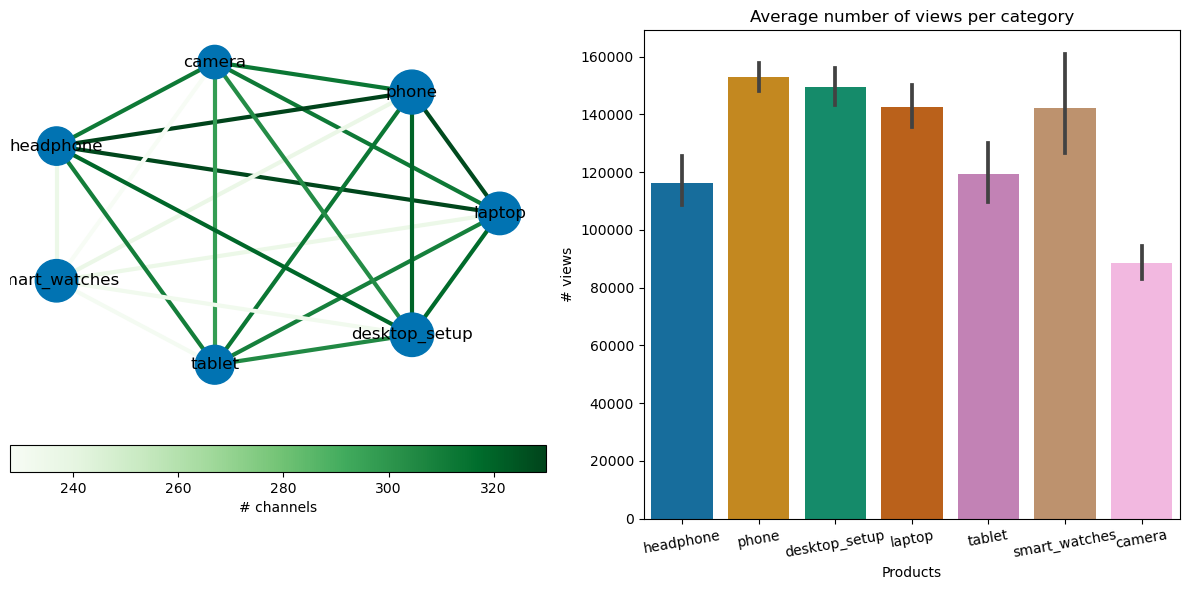

In [635]:
# Helper function for visualizing the graph
def visualize_graph(G, ax, with_labels=True, alpha=1.0):
    # get the circular layout
    pos = nx.circular_layout(G, center=[1,1]) 

    if with_labels:
        labels = {node: f"{node}" for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=labels, ax=ax)

    # plot edges with weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha, edgelist=edges, edge_color=weights, width=3, ax=ax, edge_cmap=plt.cm.Greens)

    # Add color bar for edge weights
    cbar = plt.colorbar(ec, orientation='horizontal', pad=0.1, ax=ax)
    cbar.set_label('# channels')

    # plot nodes with size
    color = sns.color_palette("colorblind",1)
    nodes,size = zip(*nx.get_node_attributes(G,'size').items())
    nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, node_size=1000*np.divide(list(size),max(list(size))), ax=ax)

# create graph
G = nx.Graph()

for _,row in all_products.iterrows():

    # add node
    for product in list(products):
        G.add_node(
            product, 
            size=node_size[node_size['product_category']==product]['view_count'].iloc[0] # mean view as node size
        )

    # add edge
    for i in range(len(products)):
        for j in range(i+1, len(products)):
            if (products[i] in row['product_category']) & (products[j] in row['product_category']):
                if G.has_edge(products[i], products[j]):
                    G[products[i]][products[j]]['weight'] += 1  # update the weight of the existing edge
                else:
                    G.add_edge(products[i], products[j], weight=1)  # add a new edge with weight 1

# visualize the plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
colors = sns.color_palette("colorblind",len(products))

visualize_graph(G,with_labels=True,ax=axes[0])
sns.barplot(data=tech_df_graph, x='product_category', y='view_count', estimator='mean', ax=axes[1], palette=colors)

axes[0].axis('off')
axes[1].set(title='Average number of views per category', xlabel='Products', ylabel='# views')
axes[1].tick_params(axis='x', rotation=10)

plt.tight_layout()
plt.show()

From the above graph we can see that the videos about _phones_, _headphones_ and _laptops_ have stronger bond compared to the other pairs, meaning most of the successful channels tend to cover the combination of these products.

### Which product categories attract more viewers?

For each video uploaded, let's get the ratio of the number of views of the video to the total number of views of the channel at the time of release of the video. Then, we want to see if any one of the products have a clearly higher ratio of views compared to the others. The reason why we are diving the number of views by the total number of views of the channel at the time of the release is to remove the current popularity of the channel.

In [636]:
# import the timeseries dataset
timeseries = pd.read_csv(PATH_DF_TIMESERIES, sep="\t", compression="infer")

# Helper function to find the index of the closest datetime
def find_closest_datetime_index(row):
    row_diff = row.copy()
    row_diff = row_diff[row_diff['upload_date'] - row_diff['datetime'] >= pd.Timedelta(0)]
    if not row_diff.empty:
        # If row_diff is not empty, return the index of the maximum datetime
        return row_diff['datetime'].idxmax()
    else:
        # If row_diff is empty, return the index of the minimum absolute time difference
        return (row['datetime'] - row['upload_date']).abs().idxmin()

# filter only the channels that focus on wider range of products and with over 100000 subscribers
top_timeseries = timeseries[timeseries.channel.isin(top_wide)]
top_videos = tech_df_prd[tech_df_prd.channel_id.isin(top_wide)]

# correct the datetime objects
top_timeseries.datetime = pd.to_datetime(top_timeseries.datetime)
top_timeseries.rename({'channel':'channel_id'},axis=1, inplace=True)
top_videos.upload_date = pd.to_datetime(top_videos.upload_date)

# merge the timeseies data of each videos
top_mt = pd.merge(top_videos[['channel_id','display_id','upload_date','view_count','product_category']],top_timeseries[['channel_id','datetime','views']],on='channel_id',how='left')
top_mt = top_mt[top_mt['upload_date']>=top_timeseries.datetime.min()]

# drop the channels with no timeseries data available
top_mt = top_mt[top_mt['datetime'].notna()]

# Group by 'channel_id' and find the index of the closest datetime for each group
closest_indices = top_mt.groupby('display_id').apply(find_closest_datetime_index)

# Get the corresponding rows from the original DataFrame
top_each = top_mt.loc[closest_indices]

# Get the views ratio
top_each['view_ratio'] = top_each['view_count'] / top_each['views']
display(top_each.sample(5))

,channel_id,display_id,upload_date,view_count,product_category,datetime,views,view_ratio
27707456,UC-v54XQalOcx5yco3aTixrg,H65oKmttMnQ,2019-07-03,12282.0,phone,2019-07-01 01:00:00,3.920464e+07,0.000313
15055431,UCOmcA3f_RrH6b9NmcNa4tdg,mNxOtIXPVKE,2016-10-23,20956.0,headphone,2016-10-17 00:00:00,5.708486e+08,0.000037
19134047,UCH3NyccoVmX0O6Bp3dlyqdw,ndyz_bwVKDg,2019-07-06,59249.0,phone,2019-07-01 01:00:00,1.690228e+07,0.003505
11358071,UCVLN0tY51ewH44wUtx3YZTA,7Wj-gzEfJ6k,2019-05-27,310231.0,phone,2019-05-27 00:00:00,2.182817e+07,0.014212
20400071,UCDt0iwnK2sPXaOyZhVmXIQw,0ZaOr6m-1rE,2017-06-21,63237.0,phone,2017-06-19 00:00:00,7.369952e+07,0.000858


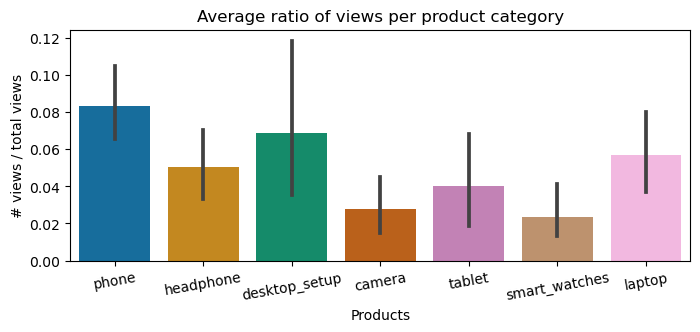

In [637]:
# plot the average ratio of views per product category
plt.figure(figsize=(8,3))
colors = sns.color_palette("colorblind",len(products))

ax = sns.barplot(
    data=top_each,
    x='product_category',
    y='view_ratio',
    estimator='mean',
    palette=colors
)
ax.set(title='Average ratio of views per product category', xlabel='Products', ylabel='# views / total views')

plt.xticks(rotation=10)
plt.show()

Here, we can see that no single product is totally outperforming the other. However it is worth mentioning that the _phones_ tend to attract more viewers compared to the _camera_ and _smart watches_.

To put it all together, we can derive the following conclusions:
1. There is no statistical difference in the number of subscriber and total views of the channels that focus on a particular tech product and those that cover a wider range of products, meaning the range of review product types does not have a noticeable influence on the channels' growth.
2. Among the successful channels that cover a wider range of tech products, the ones that attract a more viewers are _Phones_, _Desktop setup_, _Laptop_, and _Headphones_ (in the order of importance), and usually successful channels tend to produce the videos in the combination of _Phones_, _Laptop_, and _Headphones_.

# Attracting viewers by title

## Titles sentiment

# Big tech product releases

## Videos about the events

Here, we want to see the effect of publishing a video about a specific product, during the period of its release, on the growth of the channel. We first seperate the channels into 2 categories:
- The ones that have published a video about a product we are analyzing at hand.
- The ones that have NOT published a video about a product we are analyzing at hand.

Then, we compare the trend of the channel's growth over a 1 year period (6 months before and after the release of the product) to see if there is a clear distinction between them.

Let's first get the videos about each prodcut release:

In [641]:
# get the copy of the dataframes for the analysis in this section only
df_video = df_tech_review_mt.copy()
df_channel = df_tech_review_channels.copy()

# define the items, to analyze, and their release date
ITEMS = ['iphone x', 'iphone 7', 'galaxy s9']
RELEASE_DATES = {
    'iphone x': pd.to_datetime('2017-11-03'),
    'iphone 7': pd.to_datetime('2016-09-16'),
    'galaxy s9': pd.to_datetime('2018-03-16')}

# get the number of videos about each product for each channel
print('# total videos:',df_video.shape[0])
for item in ITEMS:
    df_video = find_in_name_and_tags(df_video, item, RELEASE_DATES[item])
    product_ch = df_video.groupby('channel_id',as_index=False)[[item]].sum()
    df_channel = pd.merge(df_channel,product_ch,on='channel_id',how='left')
    print(f'# video about {item}: {df_video[item].sum()}')

# print a sample of dataframe
print('# data points:',df_channel.shape[0])
display(df_channel.sample(5))

# total videos: 740018
# video about iphone x: 5735.0
# video about iphone 7: 4383.0
# video about galaxy s9: 3757.0
# data points: 1250


,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos,new_rank,iphone x,iphone 7,galaxy s9
322,2018-09-21,UCptwuAv0XQHo1OQUSaO6NHw,Max Tech,99700,146,97646.0,3.4190,71.0,323,0.0,0.0,0.0
956,2011-10-19,UCb4my3eC4w6VvPwQlBJo1Wg,Benchmark PC Tech,19900,3224,520785.0,9.6185,985.0,957,0.0,0.0,0.0
256,2014-12-15,UCjMVmz06abZGVdWjd1mAMnQ,Tech With Brett,198000,350,74073.0,3.7625,31.0,257,1.0,0.0,22.0
513,2015-07-28,UCX_8_kDmY-LkKchx4UnzQiw,TechYard,91291,1154,180836.0,5.1540,86.0,514,1.0,13.0,1.0
1010,2010-02-11,UCFe0rXKHLl4cBlVejuCgirg,Ryan Gehret,19800,694,581453.0,5.0375,146.0,1011,1.0,0.0,0.0


Before doing the comparison between 2 groups, we first want to balance these groups on the number of subscribers, frequency of uploading a video, and the ratio of tech review videos, because these features (especially the # subs and tech video ratio) might be a confounder of the growth of the channel.

Now we define the frequency as the average delay in days between publishing to consecutive videos.

Then we divide the group, that has published a video about the product, into 3 categories, as these categories require seperate analysis:
- Those that have published 1-50 videos during the period.
- Those that have published 11-50 videos during the period.
- Those that have published over 50 videos during the period.

In [642]:
# define average upload frequency per channel
tech_mt_uf = df_tech_review_mt.copy()
tech_mt_uf['upload_date'] = pd.to_datetime(tech_mt_uf.upload_date)
tech_mt_uf.sort_values(by=['channel_id','upload_date'],ascending=True,inplace=True)
tech_mt_uf['delay'] = tech_mt_uf.upload_date - tech_mt_uf.shift(1).upload_date
# set all first uploads to 0
first_upload = tech_mt_uf.groupby('channel_id',as_index=False)[['upload_date']].min()
first_upload['is_first'] = True
tech_df_upload_freq = pd.merge(tech_mt_uf,first_upload,on=['channel_id','upload_date'],how='left')
tech_df_upload_freq.is_first.fillna(False,inplace=True)
tech_df_upload_freq.loc[tech_df_upload_freq.is_first,'delay'] = pd.Timedelta(seconds=0)
tech_df_upload_freq['upload_year'] = tech_df_upload_freq.upload_date.dt.year
tech_df_upload_freq['upload_month'] = tech_df_upload_freq.upload_date.dt.month
tech_df_avg = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['delay']].mean().groupby(['channel_id','upload_year'],as_index=False)[['delay']].mean().groupby(['channel_id'],as_index=False)[['delay']].mean()
tech_df_avg.rename({'delay':'avg_delay'},axis=1,inplace=True)
tech_df_avg.avg_delay = (tech_df_avg.avg_delay / np.timedelta64(1, 'D')).astype(float)

# define dataframe for observational study
df_obs = pd.merge(df_channel,tech_df_avg,on='channel_id',how='left')

# get the ratio of tech videos
df_obs['tech_videos_ratio'] = df_obs['count_tech_videos'] / df_obs['videos_cc']
df_obs = df_obs[['channel_id','subscribers_cc','avg_delay','tech_videos_ratio'] + ITEMS]

# define 3 categories of channels
df_all = pd.DataFrame()
for item in ITEMS:
    df_bins = df_obs.copy()
    df_bins['treat'] = pd.cut(df_bins[item], [-1, 0, 10, 50, np.inf], labels=['0', '1-10', '11-50', '>50'])
    df_bins = pd.get_dummies(data=df_bins, columns=['treat'])
    # define the product type for each dataframe
    df_bins['product'] = item
    # concatonate the dataframes vertically
    df_all = pd.concat([df_all,df_bins], axis=0)

# print a sample of the preprocessed dataset
print("# data points:",df_all.shape[0]) # number of items * number of tech reviws channels
display(df_all.sample(5))

# data points: 3750


,channel_id,subscribers_cc,avg_delay,tech_videos_ratio,iphone x,iphone 7,galaxy s9,treat_0,treat_1-10,treat_11-50,treat_>50,product
545,UCIN0nfeWIUTX_Ybm7-HkvCg,44400,2.288457,0.248869,0.0,0.0,0.0,1,0,0,0,galaxy s9
903,UCp6H13dNochVBfHLDzFGU7g,23663,7.583499,0.102787,0.0,0.0,2.0,1,0,0,0,iphone 7
410,UC9hiXDhJeqBt7YPjY1QtL5Q,123000,20.291953,0.244681,5.0,0.0,2.0,1,0,0,0,iphone 7
212,UCBKH2wfmHxht7YyA2dVaWew,309006,8.157561,0.374294,5.0,17.0,18.0,0,0,1,0,galaxy s9
107,UCNovoA9w0KnxyDP5bGrOYzg,609000,10.409244,0.067232,0.0,0.0,0.0,1,0,0,0,galaxy s9


#### Balancing the groups

Now, we do a matching between the channels that have no video and each one of the above channels seperately. So that we can see the effect of releasing a different number of videos seperately:

In [ ]:
# define dataframes to store the matched groups
df_1_matched = pd.DataFrame()
df_2_matched = pd.DataFrame()
df_3_matched = pd.DataFrame()

# do the matching on each group for each product
for item in ITEMS:
    # select the current product
    df_obs = df_all[df_all['product'] == item]

    # match the 1st group
    df_1 = df_obs[(df_obs['treat_0'] == 1) | (df_obs['treat_1-10'] == 1)].drop(['treat_0','treat_11-50','treat_>50'],axis=1).rename({'treat_1-10':'treat'},axis=1)
    match_1 = balance_data(df_1,treat_column='treat',continuous_features=['subscribers_cc','avg_delay','tech_videos_ratio'])
    df_1_match = df_1.loc[match_1]
    df_1_matched = pd.concat([df_1_matched, df_1_match], axis=0)

    # match the 2nd group
    df_2 = df_obs[(df_obs['treat_0'] == 1) | (df_obs['treat_11-50'] == 1)].drop(['treat_0','treat_1-10','treat_>50'],axis=1).rename({'treat_11-50':'treat'},axis=1)
    match_2 = balance_data(df_2,treat_column='treat',continuous_features=['subscribers_cc','avg_delay','tech_videos_ratio'])
    df_2_match = df_2.loc[match_2]
    df_2_matched = pd.concat([df_2_matched, df_2_match], axis=0)

    # match the 3rd group
    df_3 = df_obs[(df_obs['treat_0'] == 1) | (df_obs['treat_>50'] == 1)].drop(['treat_0','treat_1-10','treat_11-50'],axis=1).rename({'treat_>50':'treat'},axis=1)
    match_3 = balance_data(df_3,treat_column='treat',continuous_features=['subscribers_cc','avg_delay','tech_videos_ratio'])
    df_3_match = df_3.loc[match_3]
    df_3_matched = pd.concat([df_3_matched, df_3_match], axis=0)

# plot some statistics after the match
for item in ITEMS:
    # select the current product
    df_1_current = df_1_matched[df_1_matched['product'] == item]
    df_2_current = df_2_matched[df_2_matched['product'] == item]
    df_3_current = df_3_matched[df_3_matched['product'] == item]

    # some info about the dataframe
    print(item.capitalize())
    print("# channel in group 1:",df_1_current.shape[0])
    print("# channel in group 2:",df_2_current.shape[0])
    print("# channel in group 3:",df_3_current.shape[0])

    # define the subplots and the colorblind friendly colors
    colors = sns.color_palette("colorblind",2)
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,6))

    # # plot group 1
    sns.boxplot(y=df_1_current['subscribers_cc'],x=df_1_current['treat'],ax=axes[0][0],palette=colors)
    sns.boxplot(y=df_1_current['avg_delay'],x=df_1_current['treat'],ax=axes[0][1],palette=colors)
    sns.boxplot(y=df_1_current['tech_videos_ratio'],x=df_1_current['treat'],ax=axes[0][2],palette=colors)

    axes[0][0].set(title='# subscribers',xlabel=None,ylabel=None,xticks=[])
    axes[0][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
    axes[0][2].set(title='Ratio of tech videos (days)',xlabel=None,ylabel=None,xticks=[])
    fig.text(0.52, 0.94, 'Group 1 (1-10 videos)', ha='center', weight='bold', fontsize=12)

    # plot group 2
    sns.boxplot(y=df_2_current['subscribers_cc'],x=df_2_current['treat'],ax=axes[1][0],palette=colors)
    sns.boxplot(y=df_2_current['avg_delay'],x=df_2_current['treat'],ax=axes[1][1],palette=colors)
    sns.boxplot(y=df_2_current['tech_videos_ratio'],x=df_2_current['treat'],ax=axes[1][2],palette=colors)

    axes[1][0].set(title='# subscribers',xlabel=None,ylabel=None,xticks=[])
    axes[1][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
    axes[1][2].set(title='Ratio of tech videos (days)',xlabel=None,ylabel=None,xticks=[])
    fig.text(0.52, 0.62, 'Group 2 (11-50 videos)', ha='center', weight='bold', fontsize=12)

    # plot group 3
    sns.boxplot(y=df_3_current['subscribers_cc'],x=df_3_current['treat'],ax=axes[2][0],palette=colors)
    sns.boxplot(y=df_3_current['avg_delay'],x=df_3_current['treat'],ax=axes[2][1],palette=colors)
    sns.boxplot(y=df_3_current['tech_videos_ratio'],x=df_3_current['treat'],ax=axes[2][2],palette=colors)

    axes[2][0].set(title='# subscribers',xlabel=None,ylabel=None,xticks=[])
    axes[2][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
    axes[2][2].set(title='Ratio of tech videos (days)',xlabel=None,ylabel=None,xticks=[])
    fig.text(0.52, 0.3, 'Group 3 (>50 videos)', ha='center', weight='bold', fontsize=12)

    # Create custom legend
    legend_handles = [Line2D([0], [0], color=colors[0], lw=2),
                    Line2D([0], [0], color=colors[1], lw=2)]

    # Use the custom handles in the legend
    fig.legend(handles=legend_handles, labels=['No video', 'Video'], bbox_to_anchor=(1.05, 1.05))
    
    plt.suptitle(item.capitalize(),weight='bold',fontsize=14,x=0.52,y=1)
    plt.tight_layout(h_pad=3)
    plt.show()

From the plots we can see that we manage to balance the groups quite well, except for the Group 3 in some cases, where there are relatively fewer number of channels in each group. This matching should be enough for our analysis, as further matching of groups 3 will result in even fewer data points. We cannot rely too much on the group 3, however group 1 and 2 should give us some good conclusion as they are well balanced. 

#### Channel's growth over 1 year period

Now, we want to see the rate of change of $ \frac{\text{\# monthly new subscribers}}{\text{\# total subscribers}} $ over a 1 year period. We are selecting 3 months before and after our analysis perio, i.e. 6 months before and after the product release date.

In [ ]:
# Prepare the datasets.
time_series = pd.read_csv(PATH_DF_TIMESERIES, sep="\t", compression="infer")
time_series.datetime = pd.to_datetime(time_series.datetime)
time_series.rename({'channel':'channel_id'},axis=1,inplace=True)
# Get the ratio of new subs and views
time_series['ratio_subs'] = time_series['delta_subs'] / time_series['subs']
time_series['ratio_views'] = time_series['delta_views'] / time_series['views']
# Keep the necessary columns only
time_series_obs = time_series[['channel_id','datetime','ratio_subs','ratio_views','subs']]
time_series_obs['year_month'] = pd.to_datetime(time_series_obs.datetime.dt.strftime('%Y-%m'))

In [ ]:
# trend plots
for item in ITEMS:
    # filtering the time series data: keep the ones with a datetime from 9 months before the release till 9 months after 
    time_series_product = time_series_obs[
            (time_series_obs["datetime"] > RELEASE_DATES[item]-pd.DateOffset(months=9)) & 
            (time_series_obs["datetime"] < RELEASE_DATES[item]+pd.DateOffset(months=9))
        ]

    # get the timeseries data of the 1st group
    df_1_current = df_1_matched[df_1_matched['product'] == item]
    channels_1 = df_1_current.channel_id.unique()
    df_1_time_series = time_series_product[time_series_product.channel_id.isin(channels_1)]
    df_1_time_series = pd.merge(df_1_time_series, df_1_current[['channel_id','treat']], on='channel_id', how='left') 

    # get the timeseries data of the 2nd group
    df_2_current = df_2_matched[df_2_matched['product'] == item]
    channels_2 = df_2_current.channel_id.unique()
    df_2_time_series = time_series_product[time_series_product.channel_id.isin(channels_2)]
    df_2_time_series = pd.merge(df_2_time_series, df_2_current[['channel_id','treat']], on='channel_id', how='left') 

    # get the timeseries data of the 3rd group
    df_3_current = df_3_matched[df_3_matched['product'] == item]
    channels_3 = df_3_current.channel_id.unique()
    df_3_time_series = time_series_product[time_series_product.channel_id.isin(channels_3)]
    df_3_time_series = pd.merge(df_3_time_series, df_3_current[['channel_id','treat']], on='channel_id', how='left') 

    # define the subplots and the colorblind friendly colors
    colors = sns.color_palette("colorblind",2)
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,9))

    # plot the trends of news subs and views
    sns.lineplot(data=df_1_time_series, x='year_month', y='ratio_subs', hue='treat', ax=axes[0][0])
    sns.lineplot(data=df_1_time_series, x='year_month', y='ratio_views', hue='treat', ax=axes[0][1])
    sns.lineplot(data=df_2_time_series, x='year_month', y='ratio_subs', hue='treat', ax=axes[1][0])
    sns.lineplot(data=df_2_time_series, x='year_month', y='ratio_views', hue='treat', ax=axes[1][1])
    sns.lineplot(data=df_3_time_series, x='year_month', y='ratio_subs', hue='treat', ax=axes[2][0])
    sns.lineplot(data=df_3_time_series, x='year_month', y='ratio_views', hue='treat', ax=axes[2][1])
    
    # set the vertical lines to highlight the period
    for i in range(3):
        for j in range(2):
            axes[i][j].axvline(x=RELEASE_DATES[item], color='green', linestyle='-')
            axes[i][j].axvline(x=RELEASE_DATES[item]-pd.DateOffset(months=3), color='red', linestyle='--')
            axes[i][j].axvline(x=RELEASE_DATES[item]+pd.DateOffset(months=3), color='red', linestyle='--')
            axes[i][j].tick_params(axis='x', rotation=45)

    for i in range(3):
        axes[i][0].set(title='# new subs / # total subs',xlabel=None,ylabel=None)
        axes[i][1].set(title='# new view / # total view',xlabel=None,ylabel=None)

    fig.text(0.5, 0.94, 'Group 1 (1-10 videos)', ha='center', weight='bold', fontsize=12)
    fig.text(0.5, 0.64, 'Group 2 (11-50 videos)', ha='center', weight='bold', fontsize=12)
    fig.text(0.5, 0.3, 'Group 3 (>50 videos)', ha='center', weight='bold', fontsize=12)

    plt.suptitle(item.capitalize(),weight='bold',fontsize=14,x=0.5,y=1)
    plt.xticks(rotation=45)
    plt.tight_layout(h_pad=3)
    plt.show()

As for Iphone X, we see that the channels that have produced a video about it during the 6 month period of its release have seen some increase in the growth of the channel (ratio of new subs/view to the total subs/view), while for the other channels they did not have any dramatic change in their trend. We see this difference in the increase of the trend more clearly especially for the channels that have produced between 1-50 videos, because the number of other channels is too few that we cannot see any increase that clearly (even though we see that it increased on the date of release).

_So, let's focus mostly on the channels in Group 1 and 2._

We see an interesting trend in the Group 1 and 2 of Iphone 7, namely the trend is increasing for both channels. Let's dig deeper into Group 2. We want to see what the videos were mostly about:

In [ ]:
# get the titles of the 2nd Group of Iphone 7 with no video about Iphone 7
title_sent = df_video[df_video.channel_id.isin(df_2_matched[(df_2_matched['product']=='iphone 7') & (df_2_matched['treat']==0)].channel_id.unique())].title.tolist()

# Tokenize the text into words
text = ' '.join(title_sent)
words = text.split()

# Generate bigrams and count the occurance of each
bigrams = list(ngrams(words, 2))
bigram_counts = Counter(bigrams)

# Print the 10 most occured bigrams
sorted_bigram_counts = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)
print(sorted_bigram_counts[:10])

Apparently during this time we had many videos about other tech by Xiaomi and Samsung as well. Indeed, below we list the release dates of other phones by Samsung and Xiaomi, of which the release date overlaps with the period we are interested in:
| Phone Name                    | Release Date      |
|-------------------------------|-------------------|
| Redmi Note 4G                 | June 15, 2016     |
| Redmi Note 4X                 | August 29, 2016   |
| Redmi Note 3 Pro Prime        | October 17, 2016  |
| Redmi Note 3                  | February 10, 2016 |
| Xiaomi Redmi 3S Prime         | October 17, 2016  |
| Xiaomi Redmi 3S               | June 16, 2016     |
| Xiaomi Redmi 4                | August 24, 2016   |
| Xiaomi Mi 5s                  | September 22, 2016|
| Xiaomi Mi 5s Plus             | September 22, 2016|
| Xiaomi Redmi Note 4 Plus      | August 29, 2016   |
| Samsung Galaxy A5 (2016)      | June 17, 2016     |
| Samsung Galaxy J5 (2016)      | June 22, 2016     |
| Samsung Galaxy J7 (2016)      | June 22, 2016     |
| Samsung Galaxy Grand Prime Plus| July 27, 2016    |
| Samsung Galaxy C5 Pro         | August 20, 2016   |
| Samsung Galaxy J7 Nxt         | October 21, 2016  |
| Samsung Galaxy C7 Pro         | November 8, 2016  |
| Samsung Galaxy A7 (2016)      | November 13, 2016 |


Let us now try other groups as well. For example, 2nd Group of Galaxy s9: 

In [ ]:
# get the titles of the videos of the 2nd Group of galaxy s9 with no video about galaxy s9
title_sent = df_video[df_video.channel_id.isin(df_2_matched[(df_2_matched['product']=='galaxy s9') & (df_2_matched['treat']==0)].channel_id.unique())].title.tolist()

# Tokenize the text into words
text = ' '.join(title_sent)
words = text.split()

# Generate bigrams and count the occurance of each
bigrams = list(ngrams(words, 2))
bigram_counts = Counter(bigrams)

# Print the 10 most occured bigrams
sorted_bigram_counts = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)
print(sorted_bigram_counts[:10])

Indeed we again see a similar result for this group as well, namely these are the products (other than Galaxy s9) that were released by Samsung and Xiaomi during the period of our analysis:

| Phone Name                  | Release Date      |
|-----------------------------|-------------------|
| Redmi Note 5A               | December 22, 2017 |
| Redmi Note 5A Prime         | January 24, 2018  |
| Redmi Note 5                | February 14, 2018 |
| Redmi Note 5 Pro            | March 15, 2018    |
| Redmi 6 Pro                 | April 20, 2018    |
| Redmi 6A                    | May 22, 2018      |
| Redmi S2                    | May 25, 2018      |
| Xiaomi Mi 8                 | May 29, 2018      |
| Xiaomi Mi 8 Pro             | May 29, 2018      |
| Samsung Galaxy J7 Nxt       | March 29, 2018    |
| Samsung Galaxy A8 (2018)    | April 20, 2018    |
| Samsung Galaxy J6+          | May 30, 2018      |
| Samsung Galaxy J4+          | May 30, 2018      |
| Samsung Galaxy A8+ (2018)   | May 31, 2018      |

From all the observations above, our conclusion can be that when focusing on a particular item, we can have one of the 2 following scenarios: 

- either there is a clear gain for the treat channels in terms of the number of views and subscribers such that they see an increase in the trend rate, while the other group does not inside the window between the 2 red lines.
- either no gain appears. In this case, after doing some more investigations, it seems that this could be explained by the fact that the release of the considered item overlaps with other items' releases, which the control channels talk about, in such a way that both channels see an increase in the trend rate but for different reasons (the effect of the release of the considered item is "hidden" by the release of other items, released at the same time).

Also, we can observe that the curve of the number of views and subscribers have usually a similar shape (following the same trend) for a given item, in a given group, and for a given type of channel. 

To conclude we can say, not only specific tech brands, such as iPhone, Galaxy, etc., but most of the tech product releases are a good chance to boost the channels growth by publishing some videos about them.

Let's now turn our attention to the topics discussed in those videos at different time periods ...

## Topics of videos

There are various major tech events happening throughout the year, and of course the products released in these events are a great chance for the YouTubers to attract new viewers. In this notebook we are going to analyze the period of release of iPhone X, and see how the viewers reacted to those videos.

In [36]:
# define the release date of iphone x
item = 'iphone x'
release_date = {'iphone x': pd.to_datetime('2017-11-03')}

Below we are getting the daily total number of views from the raw dataset, and finding the ratio of daily sum of views of videos about iphone x to the total views, and plotting the trend over time within 6 months of iphone x release.

Number of videos about Iphone X within 6 month of its release: 2820


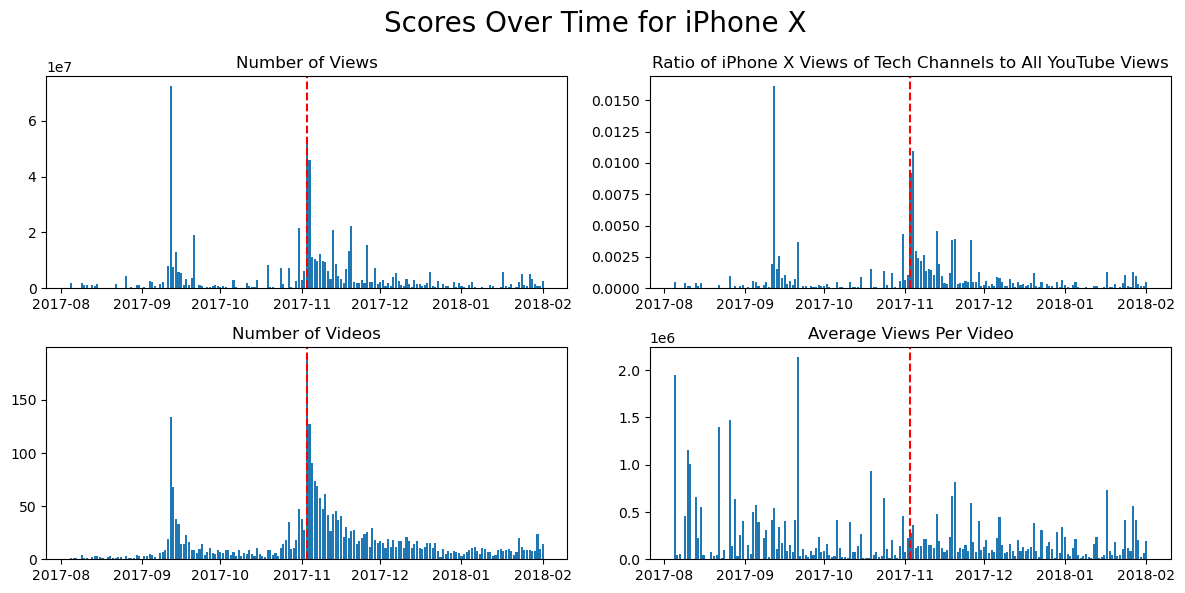

In [281]:
# 2 videos are missing title, so we ignore them
df_tech_review_mt = df_tech_review_mt[df_tech_review_mt.title.notna()]
# get only the iphone x videos
iphone_df = df_tech_review_mt[df_tech_review_mt['title'].str.lower().str.contains(item)].copy()

# from the raw dataset, we want to get the number of total views on all YouTube videos per day
yt_date_views = {}
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date", "display_id", "tags", "categories"], inplace=True, axis=1)

    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    df_json = df_json[(df_json['upload_date'] >= release_date[item] - datetime.timedelta(days=90)) & ((df_json['upload_date'] <= release_date[item] + datetime.timedelta(days=90)))]

    # get the daily sum of view counts
    youtube_views = get_sum_views(df_json)

    # for each 'upload_date, get the corresponding 'view_count' in youtube_views
    for date in youtube_views.index:
        if date in yt_date_views:
            yt_date_views[date] += youtube_views.loc[date]["view_count"]
        else:
            yt_date_views[date] = youtube_views.loc[date]["view_count"]

# 2 dataframes corresponding to number of views of all videos and the ones about iphone x per day
yt_date_views_df = pd.DataFrame.from_dict(yt_date_views, orient="index", columns=["view_count"])
iphone_date_views_df = get_sum_views(iphone_df)

# merge dataframes on the 'upload_date' column and get the ratio
merged_df = pd.merge(yt_date_views_df, iphone_date_views_df, left_index=True, right_index=True)
merged_df = merged_df.rename(columns={"view_count_x": "youtube_view_count", "view_count_y": "iphone_view_count"})
merged_df["ratio"] = merged_df["iphone_view_count"] / merged_df["youtube_view_count"]

# get some metrics of iphone x videos per day
df_score = score_per_day(iphone_df, 'iphone x', release_date[item])
print('Number of videos about Iphone X within 6 month of its release:', df_score.title.sum())

# plot the 4 curves in 4 subplots as bar graphs and for each subplot put a vertical dotted line at the release date
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axs[0][0].bar(df_score.index, df_score["view_count"])
axs[0][0].set_title("Number of Views")
axs[0][0].axvline(x=release_date[item], color="red", linestyle="--")

axs[0][1].bar(merged_df.index, merged_df["ratio"])
axs[0][1].set_title("Ratio of iPhone X Views of Tech Channels to All YouTube Views")
axs[0][1].axvline(x=release_date[item], color="red", linestyle="--")

axs[1][0].bar(df_score.index, df_score["title"])
axs[1][0].set_title("Number of Videos")
axs[1][0].axvline(x=release_date[item], color="red", linestyle="--")

axs[1][1].bar(df_score.index, df_score["view_count"] / df_score["title"])
axs[1][1].set_title("Average Views Per Video")
axs[1][1].axvline(x=release_date[item], color="red", linestyle="--")

# give a big title to the entire figure
fig.suptitle("Scores Over Time for {product_name}".format(product_name='iPhone X'), fontsize=20)
plt.tight_layout()
plt.show()

As we can see from the above plots, September 2017 and November 2017 are all months with very high user interaction with videos about the iPhone. We can also clearly see that the number of views and videos released about the iPhone X reach peaks in September and November 2017. September 2017 is the month where iPhone X was announced and November 2017 is the month where the iPhone X was released.

It is also interesting to see the ratio of videos by tech youtubers to all videos. The fact that it reached 1.5% means during theses periods the tech youtubers have chance to attract viewers from other categories as well.

We can see the Youtube platform is most active around one month before the release of a product and at the time of its release. We can also further analyse is for other major tech events to come to some conclusion.

Having seen this, we would like to know what topics are the most discussed in the videos about the iPhone. during these two periods.

In [22]:
iphone_df["upload_date"] = pd.to_datetime(iphone_df["upload_date"])

# divide the video release date into 2 part (pre, during)
pre_release = iphone_df[(iphone_df["upload_date"] <= release_date['iphone x'] - datetime.timedelta(days=30)) & (iphone_df["upload_date"] >= release_date['iphone x'] - datetime.timedelta(days=90))]
release = iphone_df[(iphone_df["upload_date"] >= release_date['iphone x'] - datetime.timedelta(days=30)) & (iphone_df["upload_date"] <= release_date['iphone x'] + datetime.timedelta(days=30))]

# keep only top 30% most viewed videos
pre_release = pre_release.sort_values(by="view_count", ascending=False)
pre_release = pre_release.iloc[:int(len(pre_release) * 0.3)]
release = release.sort_values(by="view_count", ascending=False)
release = release.iloc[:int(len(release) * 0.3)]

In [41]:
print('Pre-release topics: ')
pre_release_topics = get_lda_topics(pre_release, 3, 10)

Pre-release topics: 
Topic 1: apple, new, face, event, cnet, hand, news, best, everything, comparison
Topic 2: plus, apple, galaxy, samsung, note, hand, leak, talk, tech, camera
Topic 3: buy, galaxy, reason, plus, note, get, one, know, thing, phone


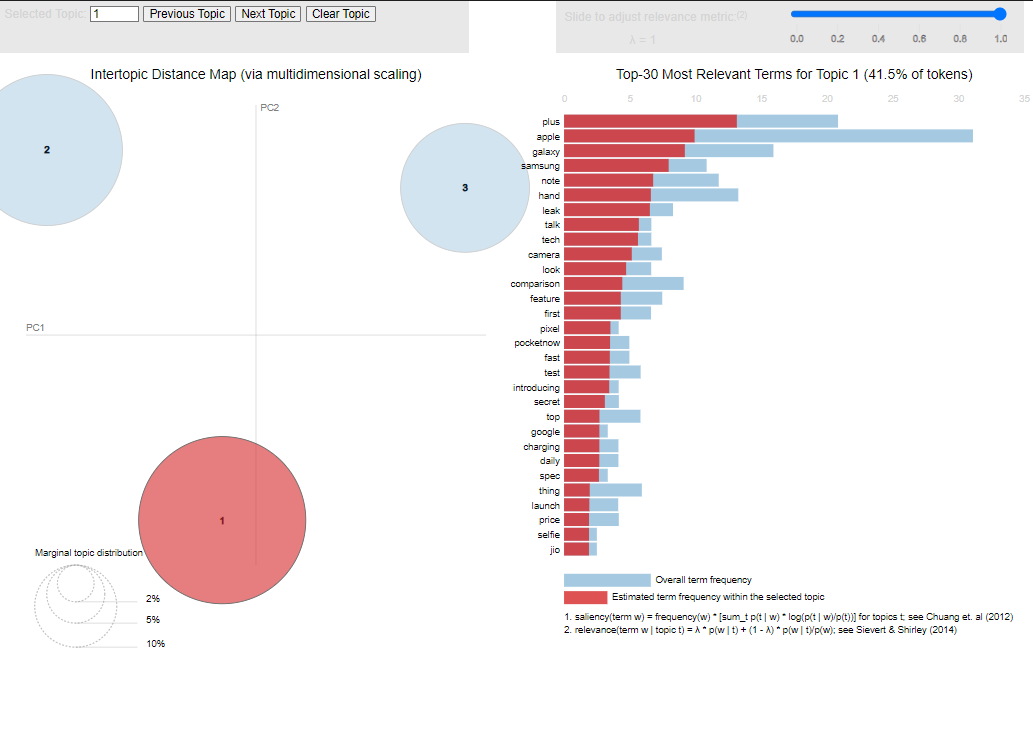

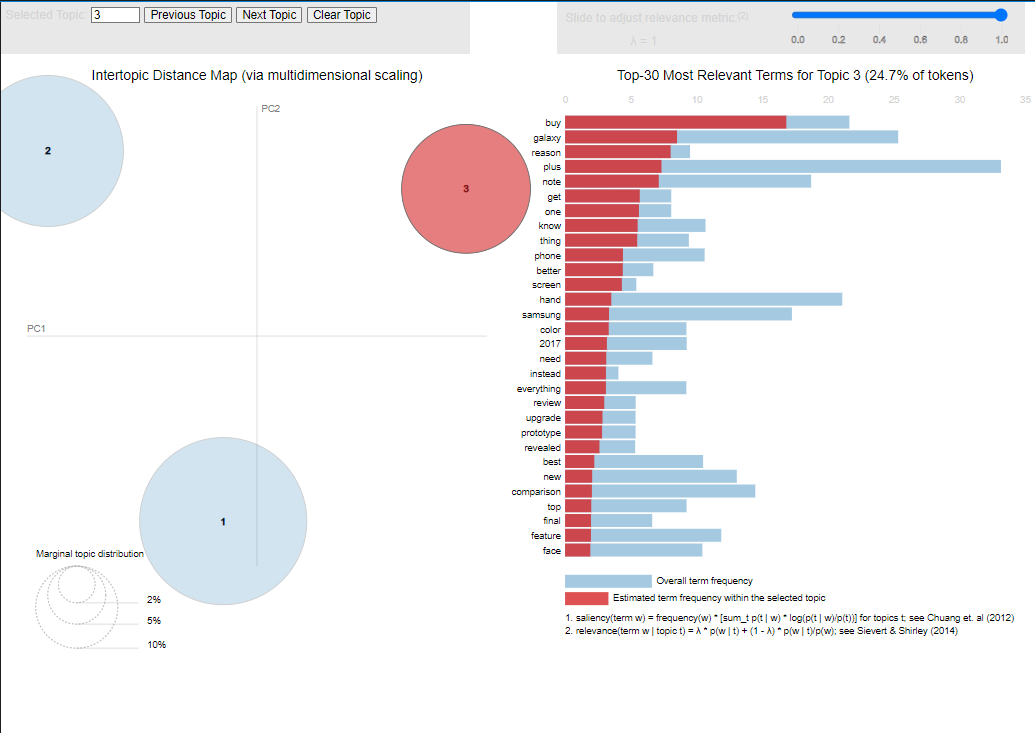

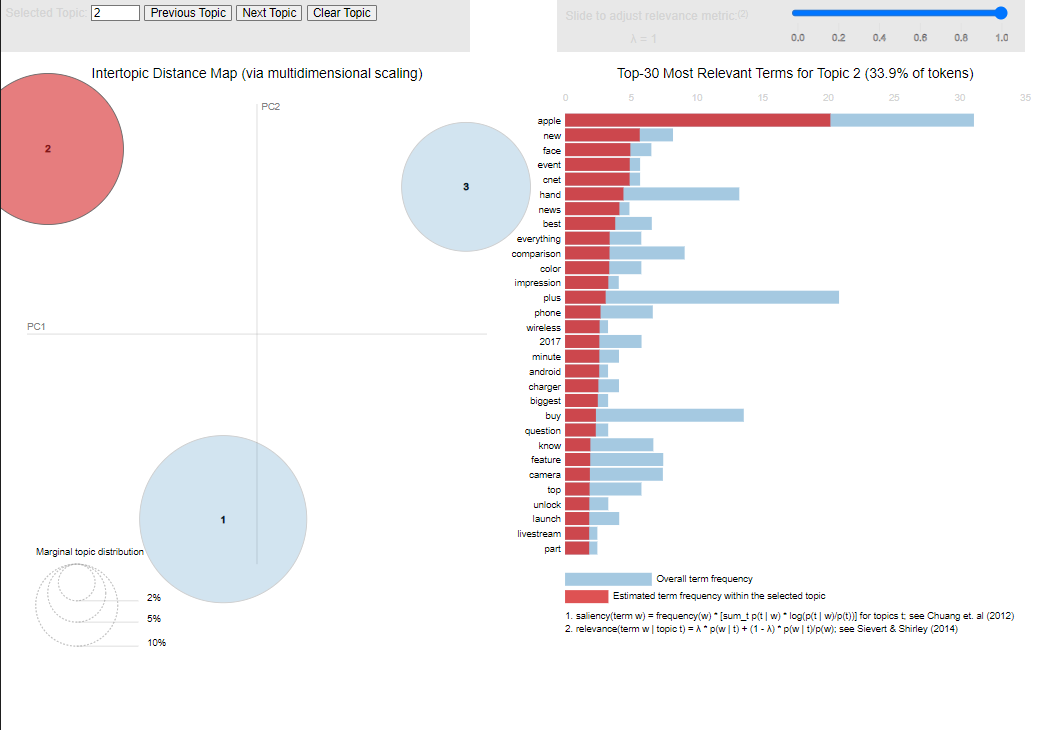

In [287]:
# Display the 3 topics of pre release period
image_paths = [
    '.\\figures\\pre_release_1.png',
    '.\\figures\\pre_release_2.png',
    '.\\figures\\pre_release_3.png'
]

for image_path in image_paths:
    img = PILImage.open(image_path)
    display(Image(filename=image_path))


In [42]:
print('During-release topics: ')
release_topics = get_lda_topics(release, 3, 10)

During-release topics: 
Topic 1: review, case, test, apple, camera, plus, speed, galaxy, best, samsung
Topic 2: unboxing, apple, first, camera, daily, pocketnow, comparison, feature, setup, review
Topic 3: test, speed, apple, note, galaxy, comparison, pixel, camera, tip, drop


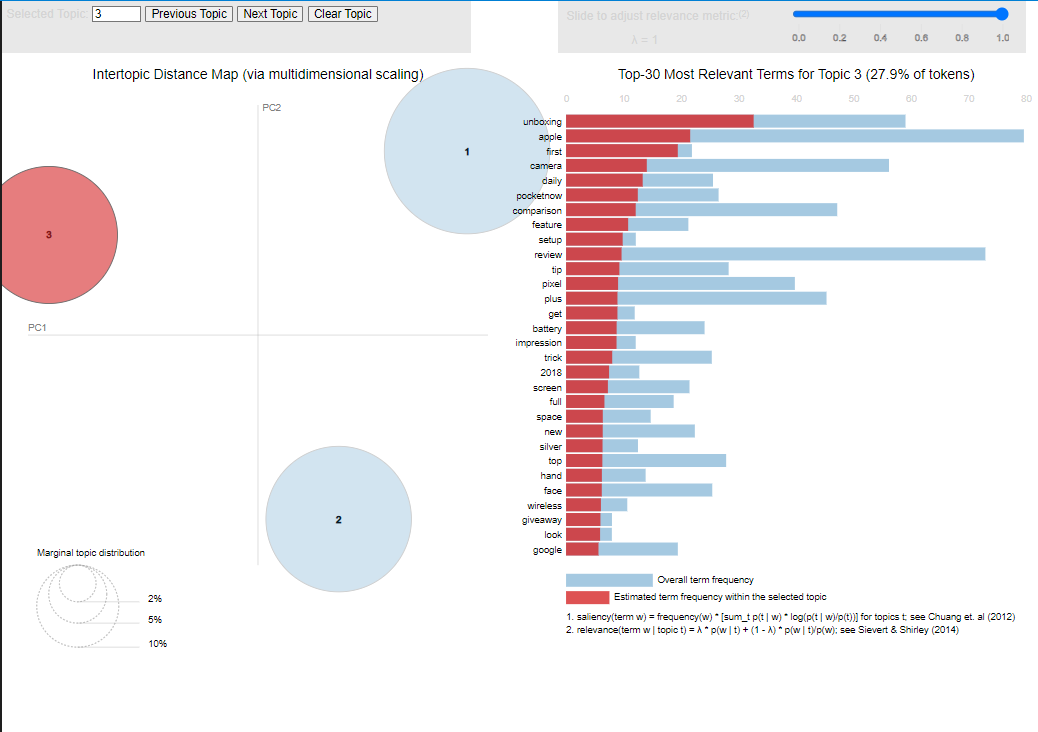

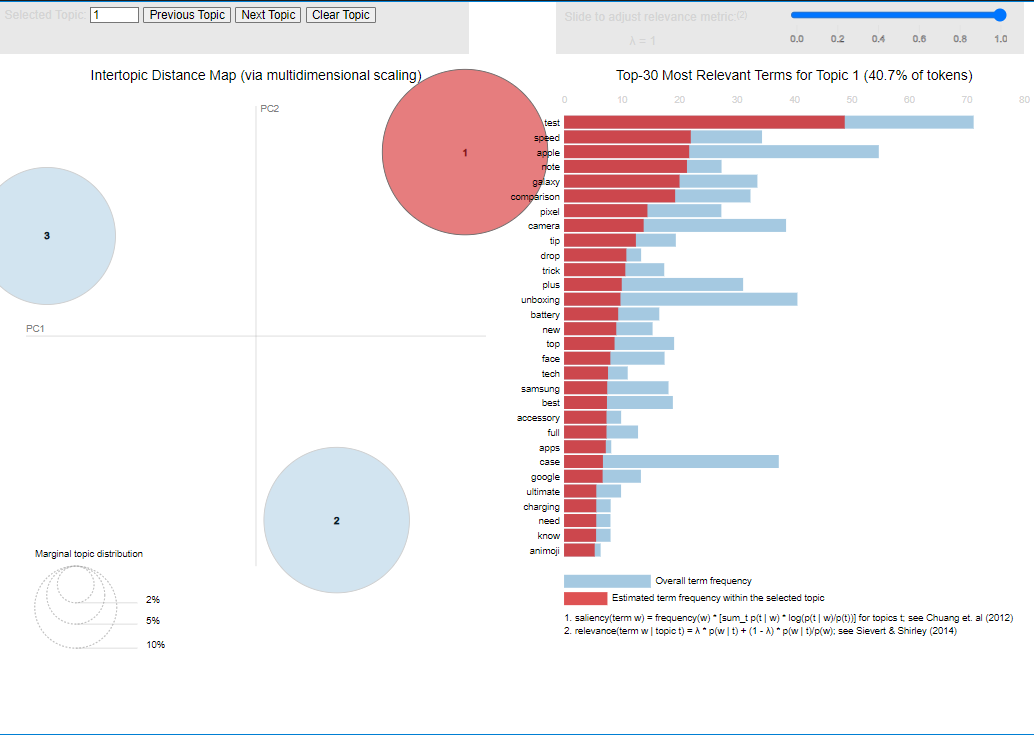

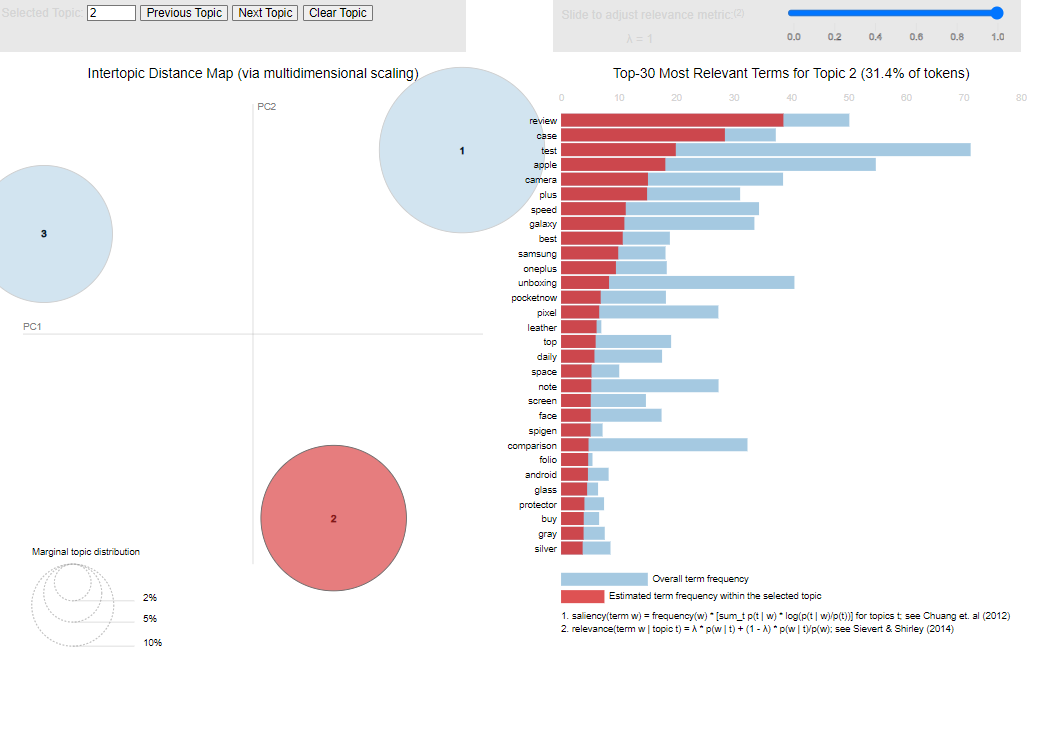

In [289]:
# Display the 3 topics of pre release period
image_paths = [
    '.\\figures\\release_1.png',
    '.\\figures\\release_2.png',
    '.\\figures\\release_3.png'
]

for image_path in image_paths:
    img = PILImage.open(image_path)
    display(Image(filename=image_path))

As we can see, topics discussed in the pre-release period and during the release period are very different.
In pre-release period, the videos mostly talk about:
- Leaking information about the iPhone X
- Unboxing of clones or possible prototypes of the iPhone X
- Possible features of the iPhone X

And during the release period, the videos mostly talk about:
- Unboxing of the iPhone X
- Reviews of the iPhone X
- Comparisons between the iPhone X and other phones
- Testing different features of the iPhone X such as the camera, the screen, the battery, etc.

Now that we know which topics are the most discussed during the pre-release and after the release of the product, we see that\
the topics are in-line with our intuition of what would make a good topic of discussion about a tech product at those specific times.

During the release period, we see that the topics discussed are nothing fancy, these are unboxing videos, reviews and comparisons.\
The pre-release period however is more interesting as it proposes very intriguing topics such as the leaking of information about the product, and the unboxing of clones or possible prototypes of the product.\
These topics are very interesting because we would assume that dealving into them would make viewers less attracted to the channel, in the following section we are going to \
see if this is truly the case:

We will perform a case study on the iPhone X by splitting channels into two groups
- The first group is the channels that have published a video about the iPhone X during the pre-release period talking about one of the topics mentioned above
- The second group is the channels that have not published any video on the iPhone X during the pre-release period and tried to hop on the wave of the release of the iPhone X

We will compare the two groups in terms of subscribers growth rate and viwers growth rate.

In [1]:
import pandas as pd
import datetime
from topics.data_extraction import DataExtractor
from topics.configs import get_config
pd.options.mode.chained_assignment = None
import topics.data_vis as vis

In [2]:
# helper class that performs all data extraction tasks
de = DataExtractor(get_config('data_extraction'))

In [3]:
# set of products to be used in the analysis
items = ['iphone x', 'iphone 6', 'galaxy s9', 'xperia xz2']
releases = ['03-11-2017', '19-09-2014', '16-03-2018', '20-04-2018']

In [4]:
# dictionary of dataframes containing all the data related to each product
product_dfs = de.products_data(items, releases)

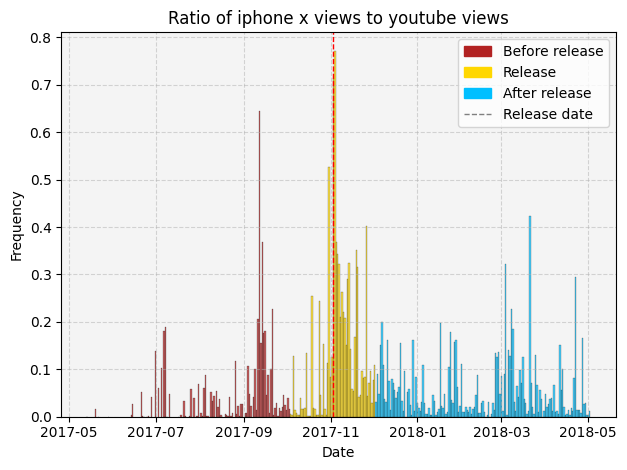

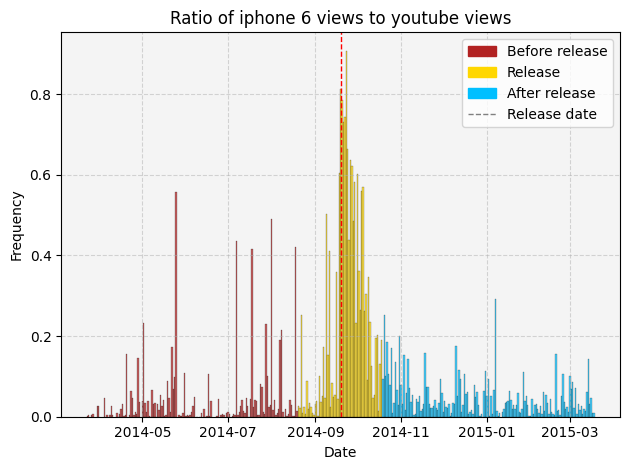

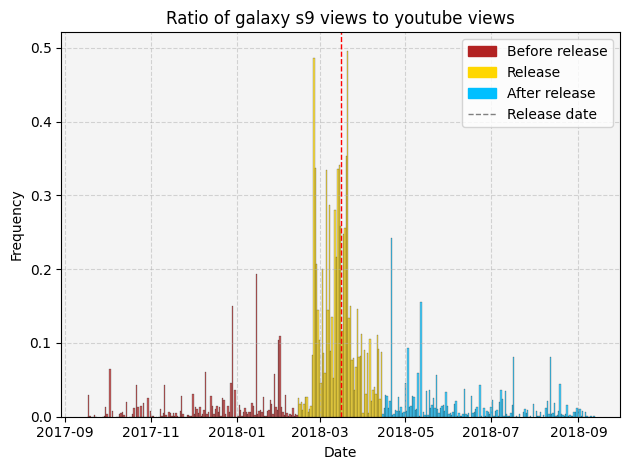

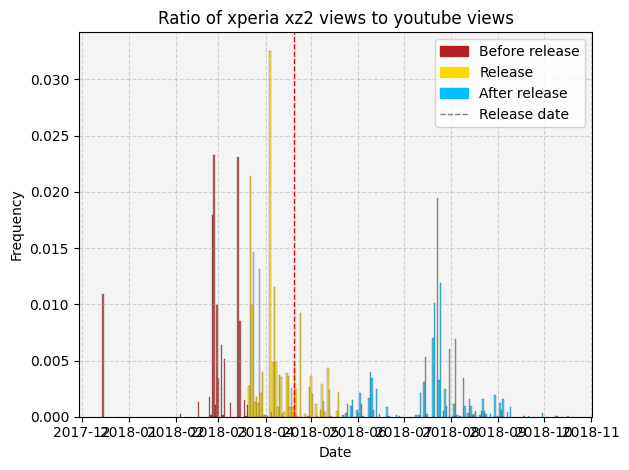

In [5]:
for i in range(len(items)):
    views = de.ratio_views(product_dfs[items[i]])
    vis.plot_product_hist(list(views.keys()), list(views.values()), releases[i], 'Ratio of '+items[i]+' views to youtube views')

This should be somewhat convincing that the release dates of products are important.\
Now the question to ask is: How can we make the most out of these release dates?\

In the previous milestone, we did a case study where we performed topic extraction on the titles of the videos\
related to the iPhone X pre-release and post-release.\
And other than the fact that the topics are very different, they are also rational since in the pre-release period,\
videos mainly addressed leaks and rumors about the iPhone X, while in the post-release period, videos were mainly about\
reviews and unboxing of the iPhone X.

Now all of this is great, but we didn't really see how videos about those specific topics impacted the overall channel growth.\
This is the question we will be answering in this milestone.

In [6]:
# lists of topic keywords
pre_release = ["leak", "unboxing", "prototype", "new", "secret"]
post_release = ["review", "unboxing", "camera", "test", "setup"]
iphone_df = product_dfs['iphone x']
pre_release_start = (datetime.datetime.strptime(releases[0], '%d-%m-%Y') - datetime.timedelta(days=400)).strftime('%d-%m-%Y')
pre_release_end = (datetime.datetime.strptime(releases[0], '%d-%m-%Y') + datetime.timedelta(days=180)).strftime('%d-%m-%Y')

In [7]:
topic_info = de.get_topic_info(iphone_df, pre_release_start, pre_release_end, pre_release)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

***
Building Up to the release Date

In [9]:
vis.plot_line(topic_info['ratio_views'], releases[0], 'Ratio of delta-views to views for iphone x channels')

In [10]:
vis.plot_line(topic_info['ratio_subs'], releases[0], 'ratio of delta subs to subs for iphone x channels')

In [11]:
vis.plot_line(topic_info['subs'], releases[0], 'Subscribers for iphone x channels')

***
Catching the wave

In [12]:
# get info about channels that did not talk about the iphone x during pre-release
wave_channels = de.get_channels_product('iphone x', releases[0])
wave_info = de.get_topic_info(wave_channels, pre_release_start, pre_release_end)

In [13]:
vis.plot_line(wave_info['ratio_views'], releases[0], 'Ratio delta-views to views for non-iphone x channels')

In [14]:
vis.plot_line(wave_info['ratio_subs'], releases[0], 'Ratio of delta subs to subs for non-iphone x channels')

In [15]:
vis.plot_line(wave_info['subs'], releases[0], 'Subscribers for non-iphone x channels')

We clearly see that the channels that try to hop on the wave of the iphone X after its release date show a\
significantly slower growth rate and absolute growth than channels that started talking about the iPhone X before its release date.

We can thus conclude that it is important to build up to a tech event if you want to make the most out of it.\
Keeping people informed about the latest news and rumors regarding a product will more likely make them interested in\
watching your review or unboxing video once the product is released.